# Shifting Paradigms in Ocean Color: Bayesian Inference for Uncertainty-Aware Chlorophyll Estimation

@author: Erdem Karaköylü<br>
@date: "2025-04-03"



## Background
Satellite ocean color remote sensing has long served as a cornerstone of marine ecosystem monitoring, offering global and synoptic coverage of surface ocean properties. Among these, chlorophyll-a ($Chl_a$) concentration remains a central metric, widely used as a proxy for phytoplankton biomass, primary production, and water quality. The retrieval of $Chl_a$ from ocean color data has evolved over decades, resulting in a diverse lineage of empirical and semi-empirical algorithms. 
These algorithms typically relate satellite-measured spectral reflectance ratios to in situ $Chl_a$ concentrations through regression models. Notable examples include the OCx family of algorithms (O'Reilly *et al.*, 1998, 2000, 2019), which utilize band ratios to estimate $Chl_a$ across a range of concentrations. While these methods have been instrumental in advancing our understanding of marine ecosystems, they often lack a rigorous quantification of uncertainty, which is crucial for informed decision-making in environmental management and policy.

## A pure Bayesian approach
The goal of this paper is to demonstrate a pure Bayesian approach and highlight its advantages with, as illustrative case, the prediction of marine surface chlorophyll from satellite remote sensing. To this end, I design multiple models of increasing complexity. This iterative development approach facilitates the building of insights into the data generation process. The modelling progression is as follows

1. I show how to recast one of the $OCx$ formulations, $OC6$ (O'Reilly et al. 2019), as a  **Bayesian polynomial regression model**;
2. To leverage more of the information contained in the dataset, I demonstrate a **Bayesian hierarchical partial pooling linear regression model**. This is inspired by an older formulation by Gordon & O'Reilly's  (1983). Here I show how this apprach avoids issues reported by these and other authors (Gordon & O'Reilly, 1983; O'Reilly *et al.* 1998) that arise from  discontinuities inherent in switching between band ratios. The efficient use of information contained in the dataset by this type of model often yields reduced predictive uncertainty. The linear formulation used here is also readily interpretable when conmpared to polynomial models like $OC6$;
3. Incoporating variance heterogeneity in model formulations, when appropriate, can be expected to improve model generalization and more accurately quantify uncertainty. As a final set of modeling expansions I demonstrate how add **heteroscedasticity as a model component**.
4. I finally show how to evaluate these models, before, and after data fitting, and how to select the best performing one. 

The reader should not expect an automated procedure; it's not the sampled data that is modeled, but the data generation process that yields to the observations on hand. The approach allows the practitioner to bring in background knowledge, and make modeling assumptions explicit, criticizable and adjustable. In consequence, a fully Bayesian modeling approach takes more thinking and intentionality than what is commonly done under the classical/frequentist paradigm. And while this means the approach is more difficulty, initially, I hope to demonstrate that the results are well worth the extra pain.

In [1]:
from pathlib import Path
from typing import Tuple

import pandas as pd
import numpy as np

import pymc as pm
import pymc_bart as pb

import arviz as az
import matplotlib.pyplot as pp
from matplotlib.axes._axes import Axes
from matplotlib.figure import Figure
import seaborn as sb

### Setup

The user should adjust the `data_path` and `img_path` variables as needed.


In [ ]:
az.style.use('arviz-darkgrid')
project_path = Path.cwd()
data_path = project_path / 'data' / '04_transformed' # User should adjst this path as needed
img_path = Path.cwd() / 'manuscript' / 'images' # User should adjst this path as needed

---

## Auxiliary Functions

In [ ]:
def plot_prior_predictive_checks(idata:az.InferenceData, model_name:str):
    f, ax = pp.subplots(figsize=(6,5))
    az.plot_ppc(idata, kind= 'cumulative', group='prior', ax=ax, observed=True)
    ax.set_xlabel('likelihod -- log(chl)')
    ax.set_ylabel('Cumulative Density Function')
    f.savefig(img_path/f'{model_name}_prior_checks.png', dpi=300)
    return f, ax

    
def plot_bayesian_regression_posterior_predictive(
        x_data: np.array, idata: az.InferenceData, ax: pp.Axes, hdi_prob: float=0.94):
    """
    Plots the Highest Density Interval (HDI) of the overall posterior
    predictive distribution for a regression model.

    Args:
        df (pd.DataFrame): DataFrame containing the original data with 'log_MBR'.
                           Used to determine the x-range for plotting.
        idata (arviz.InferenceData): InferenceData object containing the
                                          posterior_predictive samples.
                                          Assumes the predicted variable is
                                          named 'likelihood' and has no group dimension.
        ax (matplotlib.axes.Axes): The axes object to plot on.
    """

    # Select the entire posterior predictive samples for 'likelihood'.
    # Assumes no group dimension exists here.
    try:
        ppd_likelihood = idata.posterior_predictive['likelihood']
    except KeyError:
        print("Error: 'likelihood' not found in idata.posterior_predictive.")
        return
    except Exception as e:
        print(f"An error occurred selecting posterior predictive: {e}")
        return


    # Plot the Highest Density Interval (HDI) of the overall posterior predictive distribution.
    # This visualizes the expected range for new observations across all groups,
    # accounting for both uncertainty in the mean and the residual variance.
    az.plot_hdi(
        x_data,
        ppd_likelihood,
        ax=ax,
        color='black',
        hdi_prob=hdi_prob,
        fill_kwargs={'alpha': 0.30}
    )


def plot_regression_hdi(idata:az.InferenceData, X:pd.Series, y:pd.Series, hdi_prob=0.94, color=None) -> tuple[Figure, Axes]:   
    """
    Generates a posterior predictive regression plot with observed data.

    Parameters
    ----------
    idata : arviz.InferenceData
        An ArviZ InferenceData object containing the posterior predictive samples.
    X : pandas.Series
        The independent variable (e.g., log(MBR)) used in the regression.
    y : pandas.Series
        The observed dependent variable (e.g., log(Chl a)).

    Returns
    -------
    matplotlib.figure.Figure
        The generated Matplotlib Figure object.
    matplotlib.axes.Axes
        The generated Matplotlib Axes object.

    Notes
    -----
    This function assumes that `plot_bayesian_regression_posterior_predictive`
    is defined and available in the current scope. It overlays the observed
    data points on top of the posterior predictive plot.
    """
    if color is None:
        color='orange'
    fig, ax = pp.subplots(figsize=(10, 6)) # Create figure and axes
    plot_bayesian_regression_posterior_predictive(X, idata, ax=ax, hdi_prob=hdi_prob)
    ax.scatter(X, y, zorder=1, color=color, edgecolors='k', alpha=0.5)
    ax.set_title('Posterior Predictive Regression Plot')
    ax.set_xlabel('log(MBR)')
    ax.set_ylabel('log(Chl a)')
    return fig, ax

def plot_trace(idata, model_name, var_names=None, filter_vars=None):
    _ = az.plot_trace(idata, var_names=var_names, filter_vars=filter_vars)
    f_trace = pp.gcf()
    f_trace.savefig(img_path /f'{model_name}_traceplot.png', dpi=300)
    f_trace.savefig(img_path /f'{model_name}_traceplot.pdf', dpi=300)

def plot_forest(idata, model_name, var_names, filter_vars=None, save_suffix='forest_α_β_σ', kind='forest'):
    ax = az.plot_forest(
    idata, kind=kind, var_names=var_names, filter_vars=filter_vars,
    combined=True,
    figsize=(8, 3), colors=['k'], ess=True, r_hat=True)[0]
    ax.grid(color='gray')
    ax.set_yticklabels(ax.get_yticklabels(), fontdict={'size': 12})
    f_forest_model1 = pp.gcf()
    f_forest_model1.savefig(img_path / f'{model_name}_{save_suffix}.png', dpi=300)
    f_forest_model1.savefig(img_path / f'{model_name}_{save_suffix}.pdf', dpi=300)
def plot_regression_hdi_2panel(
    idata: az.InferenceData,
    model: pm.Model,
    df_train: pd.DataFrame,
    df_test: pd.DataFrame,
    hdi_prob: float = 0.94
) -> Tuple[pp.Figure, np.ndarray]:
    fig, axes = pp.subplots(1, 2, figsize=(10, 4), sharey=True, sharex=True)

    # In-sample plot
    plot_bayesian_regression_posterior_predictive(df_train["log_MBR"], idata, ax=axes[0], hdi_prob=hdi_prob)
    #axes[0].scatter(df_train["log_MBR"], df_train["log_chl"], color='orange', edgecolors='k', alpha=0.5, zorder=1)
    sb.scatterplot(df_train, x='log_MBR', y='log_chl', hue='MBR_flag', edgecolor='k', alpha=0.5, zorder=1, ax=axes[0],
                    hue_order=['Rrs411', 'Rrs443', 'Rrs489', 'Rrs510'])
    #axes[0].set_title('In-Sample Predictive Coverage')
    axes[0].set_xlabel('log(MBR)')
    axes[0].set_ylabel('log(Chl a)')

    # Prepare coords for test data
    test_coords = {"obs_idx": df_test.index}
    set_data_dict = {
        "log(MBR)": df_test["log_MBR"].values, 
        "log(chl)": df_test["log_chl"].values}


    # Only include group_idx if the model actually has it
    if "group_idx" in model.named_vars:
        mbr_type_idx, mbr_type = pd.factorize(df_test["MBR_flag"], sort=True)
        test_coords["MBR_numerator"] = mbr_type
        set_data_dict["group_idx"] = mbr_type_idx
    
    with model:
        pm.set_data(
            #{
            #    "X": df_test["log_MBR"].values,
            #    "group_idx": mbr_type_idx
            #},
            set_data_dict,
            coords=test_coords
        )
        idata_test = pm.sample_posterior_predictive(idata.posterior, var_names=["likelihood"])


    plot_bayesian_regression_posterior_predictive(df_test["log_MBR"], idata_test, ax=axes[1], hdi_prob=hdi_prob)
    #axes[1].scatter(df_test["log_MBR"], df_test["log_chl"], color='orange', edgecolors='k', alpha=0.5, zorder=1)
    sb.scatterplot(
        df_test, x='log_MBR', y='log_chl', hue='MBR_flag', edgecolor='k', alpha=0.5, zorder=1, ax=axes[1], 
        hue_order=['Rrs411', 'Rrs443', 'Rrs489', 'Rrs510'])
    #axes[1].set_title('Out-of-Sample Predictive Coverage')
    axes[1].set_xlabel('log(MBR)')

    fig.tight_layout()
    return fig, axes

## Data cleaning and transforming procedures:

* Data comes from the NOMAD v2. (2008) dataset
* Rrs signals equal to 0 were assigned NaN,
* No nulls are passed to the model,
* MBR column was pre-computed with:
    * Max of Rrs411, 443, 489 and 510 set as the numerator,
    * Rrs555 + Rrs679 set as the denominator
* A new column, MBR_flag, indicating the band  occupying the numerator in each observation was created
* log10(MBR) was precomputed as input feature
* Chlorophyll from fluorescence and HPLC were merged,
* A column flagging measurement as fluorescence or HPLC was created for modeling purposed,
* log10(chl) was precomputed as modeling target.


### Load and Examine Data

In the code below, the user should adjust the `data_path` and `img_path` variables as needed.

In [ ]:
df = pd.read_parquet(data_path / 'df_all.pqt')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1213 entries, 0 to 1212
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 1213 non-null   int64  
 1   lat                1213 non-null   float64
 2   lon                1213 non-null   float64
 3   etopo2             1213 non-null   float64
 4   oisst              1213 non-null   float64
 5   Rrs411             1213 non-null   float64
 6   Rrs443             1213 non-null   float64
 7   Rrs489             1213 non-null   float64
 8   Rrs510             1213 non-null   float64
 9   Rrs555             1213 non-null   float64
 10  Rrs670             1177 non-null   float64
 11  MBR                1213 non-null   float64
 12  log_MBR            1213 non-null   float64
 13  MBR_flag           1213 non-null   object 
 14  chl                1118 non-null   float64
 15  max_band_all_flag  1213 non-null   object 
 16  log_chl            1118 

In [ ]:
df_training = df.dropna()
df_training.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1082 entries, 0 to 1212
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 1082 non-null   int64  
 1   lat                1082 non-null   float64
 2   lon                1082 non-null   float64
 3   etopo2             1082 non-null   float64
 4   oisst              1082 non-null   float64
 5   Rrs411             1082 non-null   float64
 6   Rrs443             1082 non-null   float64
 7   Rrs489             1082 non-null   float64
 8   Rrs510             1082 non-null   float64
 9   Rrs555             1082 non-null   float64
 10  Rrs670             1082 non-null   float64
 11  MBR                1082 non-null   float64
 12  log_MBR            1082 non-null   float64
 13  MBR_flag           1082 non-null   object 
 14  chl                1082 non-null   float64
 15  max_band_all_flag  1082 non-null   object 
 16  log_chl            1082 non-n

In [8]:
# 5-random sample demo
df_training[['log_MBR', 'MBR_flag', 'log_chl', 'hplc_flag']].sample(5)

log_MBR MBR_flag   log_chl hplc_flag
934  -0.265313   Rrs510  1.219160      hplc
483   0.659631   Rrs411 -0.835647      fluo
1158 -0.189005   Rrs510  0.470116      fluo
637  -0.019404   Rrs489  0.747412      fluo
316   0.248307   Rrs489 -0.306255      fluo

## Modeling

### Approach and prelimiaries 

#### Steps in the modeling process:
1. Model definitions - multiple models are proposed, the comparison (step 6) of these models can help further understanding of processes of interest.
    * prior selection
    * model mean and variance formulation that inform how the conditional probability of the data will be evaluated
    * model structure visualization
2. Prior predictive checks:
    * Done before fitting model to data, or indeed even before collecting data,
    * Verify soundness of assumptions encoded as priors
    * run PRIOR PREDICTIVE CHECKS
    * make model generate output samples BEFORE using data and visually inspect soundness of these samples
    * if necessary modify priors and re-do step 2
3. Model fitting
    * Data passed to the model and posterior distribution is sampled using the No U-Turn Sampler (NUTS)
    * Sampling is stochastic and therefore done multiple times to verify convergence
4. Trained model evaluation
    * Sampling diagnostics is evaluated
    * Visualize model parameter posterior distributions
5. Posterior predictive checks
    * Evaluate in-sample predictions to verify that data simulated by the trained model is conform to the observed;
    * Evaluate out-of-sample inputs (i.e. not seen by the model before) are used to compute predictions and their uncertainty, which in term are plotted in conjunction with out-of-sample outputs. In machine learning this is an accepted way of verifying model generalization.
6. Model comparison part I: Using expected log pointwise predictive density. 
    * Rank model by expected performance on unseen data using two approaches
    * Watanabe-Akaike Information Criterion (WAIC) - a truly Bayesian Information Criterion that uses the full posterior and penalizes model complexity
    * Pareto Smoothed Importance Sampling Leave-One-Out Cross-Validation (PSIS-LOOCV) - an approximation of a full model refitting with N-1 samples, with the N'th sample used for evaluation, repeated N times. The approximation allow the circumvention of the $O(N^2)$ complexity of a full LOOCV run.

#### Model types 

Below I define six Bayesian models with increasing levels of complexity. These can grouped into 2 types of categories. The first categorical type is *single-level* vs *multi-level (or hierarchical partial pooling)*; the second, *homoscedastic* vs *heteroscedastic*. 
Single-level, Homoscedastic:
* Model 1: Fouth degree polynomial regression 

Multi-level, Homoscedastic:
* Model 2: Hierarchical partial pooling linear regression model with constant variance

Multi-level, Heteroscedastic:
* Model 3: Hierarchical partial pooling linear regression model with group-wise constant variance 
* Model 4: Hierarchical partial pooling linear regression model with linear variance 
* Model 5: Hierarchical partial pooling linear regression model with group-wise linear variance
* Model 6: Hierarchical partial pooling linear regression model with group-wise linear variance and chlorophyll measurment method discrimination.


Before defining models, I first define data handling coordinate for the various models to use. I also isolate the observed model inputs $log(MBR)$ and modeling target $log(Chl)$, respectively given the shorthands $X$ and $y$ in the below equations and model codes. Note that it is not customary in Bayesian modeling to use a hold-out set. This is considered a waste of information that could be instead benefit the model. In classic machine learning when new data become available a model must be completely retrained. Instead a Bayesian model's posterior is simply updated, with the posterior from the last training session becoming the new prior. The new data results then in an updated posterior. Goodness-of-fit is assessed through a number of proabilistic and information theoretic concepts which are explained in the relefant sections.

#### Modeling Heteroscedasticity

To evaluate the role of heteroscedasticity in chlorophyll prediction, we next consider three distinct dispersion parameter formulations, each specifying a different structure for the standard deviation parameter σ in the Truncated Normal likelihood:



1. Group-specific constant dispersion parameter (Model #4):
Each group (defined by MBR band numerator) received its own constant dispersion parameter term:



$$
\sigma_i \sim \text{Gamma}(\sigma_{\gamma}, \sigma_{\phi}) \tag{1}
$$

$$
\sigma = \sigma_i[\text{group\_idx}] \tag{2}
$$

2. Global linear dispersion parameter model (Model #5):
Here, dispersion parameter was modeled as a log-linear function of the predictor (log-transformed MBR), shared across all groups, with each term receiving a weakly informative prior:


$$
\sigma_{\alpha}\sim \mathcal{N}(\mu_{\alpha}, \tau_{\alpha}) \tag{3}
$$

$$
\sigma_{\beta} \sim \mathcal{N}(\mu_{\beta}, \tau_{\beta}) \tag{4}
$$

$$
\log \sigma = \sigma_{\alpha} + \sigma_{\beta} X \tag{5}
$$

$$
\sigma = \exp(\log \sigma) \tag{6}
$$

3. Hierarchical linear dispersion parameter model (Model #6):
A hierarchical formulation was used where both the intercept and slope of the log-linear dispersion parameter model were allowed to vary by group, with partial pooling:

$$
\sigma_{\alpha}^{(i)} \sim \mathcal{N}(\mu_{\alpha}, \tau_{\alpha}) \tag{7}
$$

$$
\sigma_{\beta}^{(i)} \sim \mathcal{N}(\mu_{\beta}, \tau_{\beta}) \tag{8}
$$

$$
\log \sigma^{(i)} = \sigma_{\alpha}^{(i)} + \sigma_{\beta}^{(i)} X \tag{9}
$$
$$
\sigma^{(i)} = \exp(\log \sigma^{(i)}) \tag{10}
$$

In [9]:
# Create coordinates for modeling with PyMC
# assign features and target to

mbr_type_idx, mbr_type = df_training.MBR_flag.factorize(sort=True)
chl_type_idx, chl_type = df_training.hplc_flag.factorize(sort=True)
λ_Rrs_idx, λ_Rrs = df_training.filter(like='Rrs').columns.factorize(sort=True)
COORDS = {
    'MBR_numerator': mbr_type,
    'chl_type': chl_type,
    'obs_idx': df_training.index,
    'λ_Rrs': λ_Rrs
}

X = df_training.log_MBR
y = df_training.log_chl
X_RRS_log = np.log10(df_training.filter(like='Rrs'))

### STEP 1 - Model Definitions

#### Model 1 - Bayesian Modified OC6
Here the model is almost similar to that proposed by O'Reilly et al (2019) in that the independent term of the polynomial, $X$, the Max Band Ratio (MBR) expression has for denominator is the sum of the green (555nm) and red (670nm) reflectances (Rrs), rather than the mean.

Note that for this and subsequent models the *Gamma* distribution is used as a prior for the group-specific dispersion parameter terms $\sigma_i$ due to its support on positive real values $(0, \infty)$ and its flexibility in shaping both low- and high-variance regimes. Unlike the commonly used HalfNormal or Exponential priors, the Gamma distribution allows control over both the mean and dispersion of $\sigma_i$ via its shape ($\sigma_\gamma$) and rate ($\sigma_\phi$) parameters. This is particularly useful when modeling biological or environmental data where dispersion parameter may vary substantially across groups but must remain strictly positive.

Mathematically this models can be defined as:
$$
\begin{align*}
    \alpha &\sim \text{Normal}(0, 1) \\
    \beta_1 &\sim \text{Normal}(0, 1) \\
    \beta_2 &\sim \text{Normal}(0, 1) \\
    \beta_3 &\sim \text{Normal}(0, 1) \\
    \beta_4 &\sim \text{Normal}(0, 1) \\
    \mu_i &= \alpha + \beta_1 X + \beta_2 X^2 + \beta_3 X^3 + \beta_4 X^4 \\
    \sigma &\sim \text{Gamma}(2, 2) \\
    y_i &\sim \text{TruncatedNormal}(\mu, \sigma, -3, 3.2)
\end{align*}
$$

In [10]:
with pm.Model(coords=COORDS) as model1:
    x_data = pm.Data('log(MBR)', X.values, dims='obs_idx')
    y_data = pm.Data('log(chl)', y.values, dims='obs_dix')
    α = pm.Normal('α', mu=0, sigma=1) # intercept
    β1 = pm.Normal('β1', mu=0, sigma=1) # slope for X
    β2 = pm.Normal('β2', mu=0, sigma=1) # slope for X^2
    β3 = pm.Normal('β3', mu=0, sigma=1) # slope for X^3
    β4 = pm.Normal('β4', mu=0, sigma=1) # slope for X^4
    μ = α + β1 * x_data + β2 * (x_data**2) + β3 * (x_data**3) + β4 * (x_data**4)
    σ = pm.Gamma('σ', 2, 2)
    likelihood = pm.TruncatedNormal(
        'likelihood', mu=μ, sigma=σ, lower=-3, upper=3.3, observed=y_data, dims='obs_idx'
        )

→ Plot model 1 structure (as a DAG)

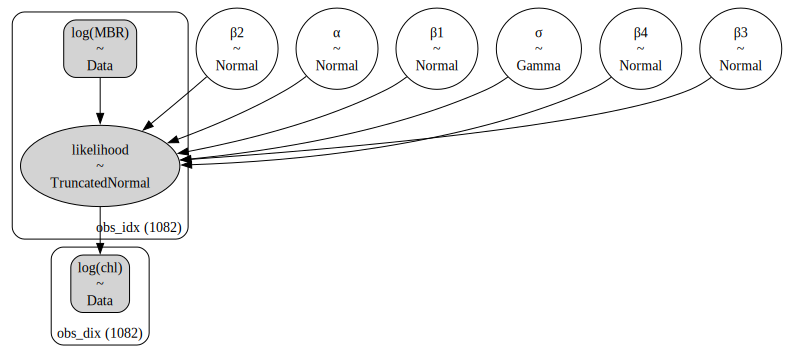

In [11]:
model1.to_graphviz()

In [12]:
g1 = model1.to_graphviz()
g1.render(filename='model1_structure', directory=img_path, format='pdf')

'/Users/erdemkarakoylu/projex/bayesian_chl/manuscript/images/model1_structure.pdf'

#### Model 2 -  Hierarchical Partially Pooled Linear Max Band Ratio (MBR) Model


Here we start similarly to Gordon et al (1983) but use an approach that circumvents discontinuities reported from switching between blue bands. Thus:
* We compute Max Band Ratio (MBR) as in our Bayesian OC6 model; 
    * the numerator is the maximum of Rrs411, Rrs443, Rrs489, Rrs510,
    * the denomiator is the sum of Rrs555 and Rrs670
    * we track the band used in numerator by adding a "MBR_flag" in our data 
* We segregate the data into 4 groups, each corresponding to the MBR numerator.
* We use a hierarchical partially pooled formulation to:
    * Take advantage of the group structure in the data
    * Maximize the use of the available data (see below)
    * Each group receives its own model slope and intercept parameters
    * These parameters have common hyperpriors (see model graph below)
        * Hyperpriors enabl the sharing of information between groups as the model is being fit
    

##### Explanation - Grouping by Spectral Dominance for Hierarchical Modeling
An expanded version of the grouping approach considers the maximum Rrs value across all key spectral bands—blue, green, and red—to define group membership. This method reflects the dominant optical signal in each observation, which often corresponds to different water types or biogeophysical regimes:

* **Rrs$\_{411}\$-dominant**: Typically associated with ultra-clear, oligotrophic waters. High reflectance at this wavelength implies minimal absorption by both phytoplankton and CDOM, suggesting extremely low pigment concentration and low scattering.
* **Rrs$\_{443}\$-dominant**: Often found in moderately clear Case-1 waters where phytoplankton absorption is just beginning to affect the spectrum. This group may indicate the presence of picoplankton or lightly productive systems.
* **Rrs$\_{489}\$-dominant**: Represents more productive Case-1 waters with moderate phytoplankton biomass. Reflectance here implies a stronger blue signal retained due to a balance of absorption and scattering.
* **Rrs$\_{510}\$-dominant**: Reflects water with increasing influence from particulate scattering, often signaling turbid phytoplankton-rich environments or transitions to Case-2 water.

Using this expanded spectral dominance scheme as a hierarchical grouping variable enables the model to learn distinct relationships between the empirical index and chlorophyll concentration that correspond to different optical regimes. Even if there is overlap in the scatter of individual data points across groups, systematic differences in slope or intercept—common across these spectral classes—justify the use of group-specific structure.

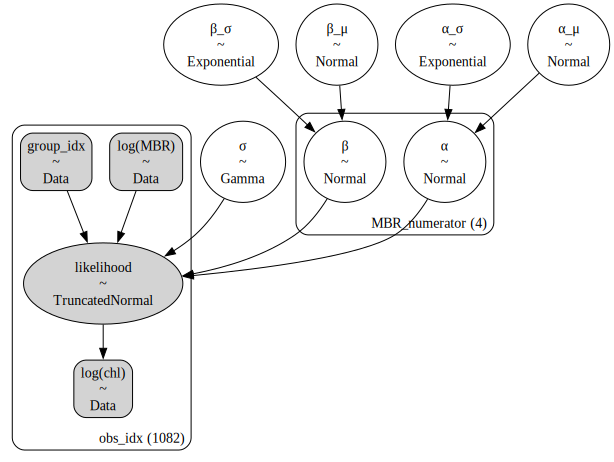

In [12]:
with pm.Model(coords=COORDS) as model2:
    # Register group index and predictor with obs dimensions
    group_idx = pm.Data(
        'group_idx', mbr_type_idx, dims='obs_idx')
    x_data = pm.Data('log(MBR)', X.values, dims='obs_idx')
    y_data = pm.Data('log(chl)', y.values, dims='obs_idx')
    # ------- Hyper-priors ---------
    α_μ = pm.Normal('α_μ', 0, 1)
    α_σ = pm.Exponential('α_σ', 1)
    β_μ = pm.Normal('β_μ', 0, 1)
    β_σ = pm.Exponential('β_σ', 1)
    # ------- Priors ---------------
    α = pm.Normal('α', α_μ, α_σ, dims='MBR_numerator')
    β = pm.Normal('β', β_μ, β_σ, dims='MBR_numerator')
    σ = pm.Gamma('σ', 2, 2)

    μ = α[group_idx] + β[group_idx] * x_data
    likelihood = pm.TruncatedNormal(
        'likelihood', mu=μ, sigma=σ, lower=-3, upper=3.2, 
        observed=y_data, dims='obs_idx')
model2.to_graphviz()


In [14]:
g2 = model2.to_graphviz(figsize=(7, 4))
g2.render(filename='model2_structure', directory=img_path, format='pdf')

'/Users/erdemkarakoylu/projex/bayesian_chl/manuscript/images/model2_structure.pdf'

---
#### Model 3. Hierarchical Partial Pooling Model with Group-Wise dispersion parameter (σ) Term

Because there is reason to suspect correlation betwee target and predictor is different between groups, it is by extension reasonable to suspect different dispersion regime between groups as well. This next model examines this possibility by assigning a dispersion parameter $σ$ to each group. I nevertheless maintain the hierarchical partial pooling structure for these parameter as well to allow information exchange and maximize dataset usage. Note that $log ( σ )$ is sampled. This is to stabilize the variance, which in my experience can lead to overflow of the Truncated Normal, particularly  in a hierarchical settings.  

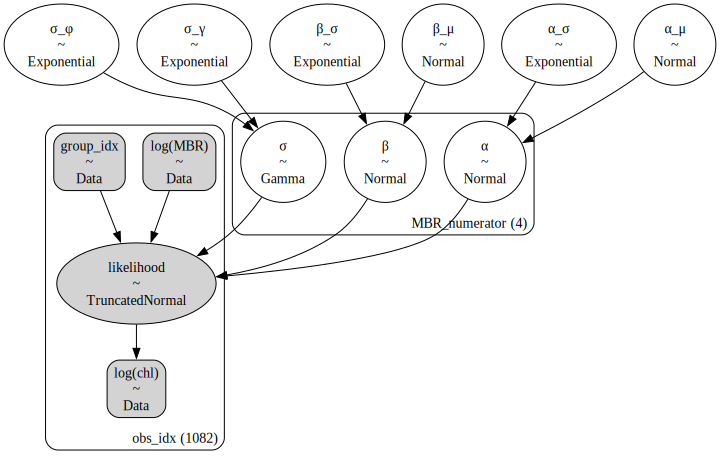

In [13]:
# Model # 3
with pm.Model(coords=COORDS) as model3:
    
    # Register group index and predictor with obs dimensions
    group_idx = pm.Data('group_idx', mbr_type_idx, dims='obs_idx')
    x_data = pm.Data('log(MBR)', X.values, dims='obs_idx')
    y_data = pm.Data('log(chl)', y.values, dims='obs_idx')

    # ------- Hyper-priors ---------
    α_μ = pm.Normal('α_μ', 0, 1)
    α_σ = pm.Exponential('α_σ', 1)
    β_μ = pm.Normal('β_μ', 0, 1)
    β_σ = pm.Exponential('β_σ', 1)
    σ_γ = pm.Exponential('σ_γ', 1)
    σ_φ = pm.Exponential('σ_φ', 1)

    # ------- Priors ---------------
    α = pm.Normal('α', α_μ, α_σ, dims='MBR_numerator')
    β = pm.Normal('β', β_μ, β_σ, dims='MBR_numerator')
    σ_ = pm.Gamma('σ', σ_γ, σ_φ, dims='MBR_numerator')

    # ------- Likelihood ------------
    μ = α[group_idx] + β[group_idx] * x_data
    σ = σ_[group_idx]
    likelihood = pm.TruncatedNormal(
        'likelihood', mu=μ, sigma=σ, 
        lower=-3, upper=3.2, observed=y_data, dims='obs_idx')

model3.to_graphviz()

In [16]:
g3 = model3.to_graphviz()
g3.render(filename='model3_structure', directory=img_path, format='png')
g3.render(filename='model3_structure', directory=img_path, format='pdf')

'/Users/erdemkarakoylu/projex/bayesian_chl/manuscript/images/model3_structure.pdf'

---
#### Model 4 - Hierarchical Partiall Pooling Linear Model with Linear Heteroscedasticity

This model explores the question: $\text{"Is variance linearly related to the data?"}$. For this the log of the variance $σ$ of the target $log(Chl)$ is modeled as a linear regression of the input, $X$. Note that 
1. The log of the variance is modeled for numerical stability and domain compatibility (variance should be positive). Thus it is tranformed by exponentiation before being passed on to the likelihood.
2. Unlike the mean, the variance sub-model is not hierachical partially pooled, because I first look to see if 

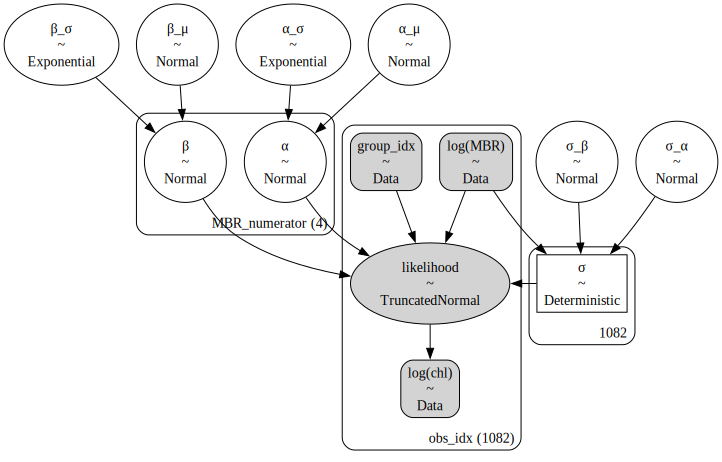

In [14]:
with pm.Model(coords=COORDS) as model4:
    # Register group index and predictor with obs dimensions
    group_idx = pm.Data('group_idx', mbr_type_idx, dims='obs_idx')
    x_data = pm.Data('log(MBR)', X.values, dims='obs_idx')
    y_data = pm.Data('log(chl)', y.values, dims='obs_idx')
    # ------- Hyper-priors ---------
    α_μ = pm.Normal('α_μ', 0, 1)
    α_σ = pm.Exponential('α_σ', 1)
    β_μ = pm.Normal('β_μ', 0, 1)
    β_σ = pm.Exponential('β_σ', 1)

    # ------- Priors ---------------
    α = pm.Normal('α', α_μ, α_σ, dims='MBR_numerator')
    β = pm.Normal('β', β_μ, β_σ, dims='MBR_numerator')
    σ_α = pm.Normal('σ_α', 0, 1)
    σ_β = pm.Normal('σ_β', 0, 1)
   
    μ = α[group_idx] + β[group_idx] * x_data
    log_σ = σ_α + σ_β * x_data
    σ = pm.Deterministic('σ', pm.math.exp(log_σ))
    likelihood = pm.TruncatedNormal(
        'likelihood', mu=μ, sigma=σ, lower=-3, upper=3.2, 
        observed=y_data, dims='obs_idx')
model4.to_graphviz()


In [18]:
g4 = model4.to_graphviz()
g4.render(filename='model4_structure', directory=img_path, format='png')
g4.render(filename='model4_structure', directory=img_path, format='pdf')

'/Users/erdemkarakoylu/projex/bayesian_chl/manuscript/images/model4_structure.pdf'

----
#### Model 5 - Hierarchical Partial Pooling Linear Model with Hierarchical Linear Heteroscedasticity

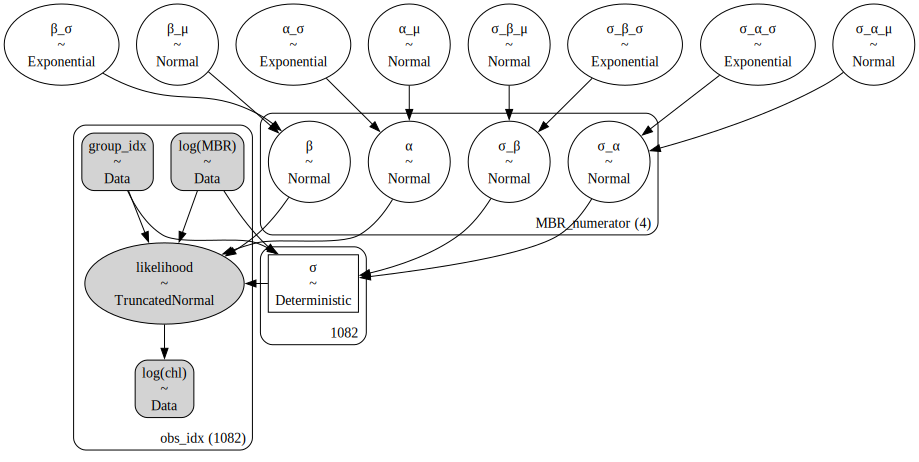

In [15]:
with pm.Model(coords=COORDS) as model5:
    # Register group index and predictor with obs dimensions
    group_idx = pm.Data('group_idx', mbr_type_idx, dims='obs_idx')
    x_data = pm.Data('log(MBR)', X.values, dims='obs_idx')
    y_data = pm.Data('log(chl)', y.values, dims='obs_idx')
    # ------- Hyper-priors ---------
    # μ (mean) term
    α_μ = pm.Normal('α_μ', 0, 1)
    α_σ = pm.Exponential('α_σ', 1)
    β_μ = pm.Normal('β_μ', 0, 1)
    β_σ = pm.Exponential('β_σ', 1)
    # σ (dispersion parameter) term
    σ_α_μ = pm.Normal('σ_α_μ', 0, 1)
    σ_α_σ = pm.Exponential('σ_α_σ', 1)
    σ_β_μ = pm.Normal('σ_β_μ', 0, 1)
    σ_β_σ = pm.Exponential('σ_β_σ', 1)
    
    # ------- Priors -----------------
    α = pm.Normal('α', α_μ, α_σ, dims='MBR_numerator')
    β = pm.Normal('β', β_μ, β_σ, dims='MBR_numerator')
    σ_α = pm.Normal('σ_α', σ_α_μ, σ_α_σ, dims='MBR_numerator')
    σ_β = pm.Normal('σ_β', σ_β_μ, σ_β_σ, dims='MBR_numerator')
    
    # ------ Likelihood --------------
    #σ_ = pm.Gamma('σ_', σ_γ, σ_φ, dims='MBR_numerator')
    μ = α[group_idx] + β[group_idx] * x_data
    log_σ = σ_α[group_idx] + σ_β[group_idx] * x_data
    σ = pm.Deterministic('σ', pm.math.exp(log_σ))
    likelihood = pm.TruncatedNormal(
        'likelihood', mu=μ, sigma=σ, lower=-3, upper=3.2, observed=y_data, dims='obs_idx')
model5.to_graphviz()


In [20]:
g5 = model5.to_graphviz()
g5.render(filename='model5_structure', directory=img_path, format='png')
g5.render(filename='model5_structure', directory=img_path, format='pdf')

'/Users/erdemkarakoylu/projex/bayesian_chl/manuscript/images/model5_structure.pdf'

---
---

### STEP 2 - Prior Predictive Checks 

Running prior predictive checks (Prior PC) to ensure reasonable assumptions encoded as priors. This means sampling models and getting assumptions based outputs before even fitting data. This is possible because Bayesian models are generative. Below are the code invoking Prior PC and visualization of the prior-based predictions. Do store the results, I instantiate and Arviz.InferenceData object, with nomenclature idataModel#.

#### Model 1

In [16]:
PPC_COLORS = ['darkgray', 'k', 'C1']

In [17]:
with model1:
    idata1 = pm.sample_prior_predictive()
with model2:
    idata2 = pm.sample_prior_predictive()
with model3:
    idata3 = pm.sample_prior_predictive()
with model4:
    idata4 = pm.sample_prior_predictive()
with model5:
    idata5 = pm.sample_prior_predictive()

Sampling: [likelihood, α, β1, β2, β3, β4, σ]
Sampling: [likelihood, α, α_μ, α_σ, β, β_μ, β_σ, σ]
Sampling: [likelihood, α, α_μ, α_σ, β, β_μ, β_σ, σ, σ_γ, σ_φ]
/Users/erdemkarakoylu/miniconda3/envs/pymc_base/lib/python3.12/site-packages/pymc/distributions/continuous.py:547: RuntimeWarning: divide by zero encountered in divide
  a=((lower - mu) / sigma).astype("float64"),
/Users/erdemkarakoylu/miniconda3/envs/pymc_base/lib/python3.12/site-packages/pymc/distributions/continuous.py:548: RuntimeWarning: divide by zero encountered in divide
  b=((upper - mu) / sigma).astype("float64"),
Sampling: [likelihood, α, α_μ, α_σ, β, β_μ, β_σ, σ_α, σ_β]
Sampling: [likelihood, α, α_μ, α_σ, β, β_μ, β_σ, σ_α, σ_α_μ, σ_α_σ, σ_β, σ_β_μ, σ_β_σ]


Plot prior predictive check, using the cumulative density option.

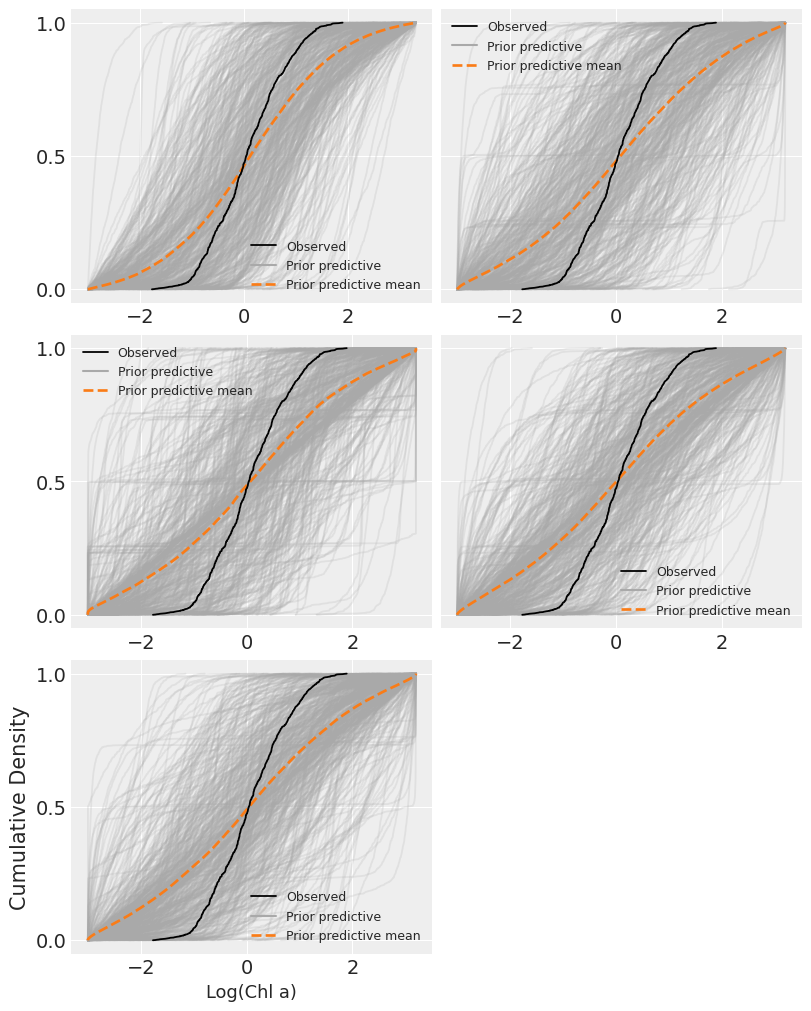

In [27]:
f, axs = pp.subplots(figsize=(8,10), sharey=True, nrows=3, ncols=2)

for i, (ax, idata) in enumerate(zip(axs.ravel(), [idata1, idata2, idata3, idata4, idata5])):
    az.plot_ppc(
        idata, kind= 'cumulative', group='prior', ax=ax, 
        observed=True, textsize=12, colors=PPC_COLORS)
    ax.set_xlabel('')
if i % 2 == 0:
    ax.set_ylabel('Cumulative Density')
if i>2:
    ax.set_xlabel('Log(Chl a)')
axs.ravel()[-1].set_visible(False)
#axs.ravel()[-1].set_xticks([])
#f.savefig(img_path / 'model1_prior_pc.png', dpi=300)
#f.savefig(img_path / 'model1_prior_pc.pdf', dpi=300)

---
---
### STEP 3 - Model Fitting

In Bayesian modeling, “fitting a model” refers to computing the posterior distribution of the model parameters given the data. Since this distribution is usually not available in closed form, we sample from it using MCMC-type algorithms. Thus Model fitting in this context refers to numerically approximating the posterior distribution. Often fitting is interchanged with "Sampling", which refers to the computational procedure used to perform this approximation by drawing samples from p(model parameters | data). See below for further explanation on the sampling procedure used.

Mathematically the **posterior distribution** of the model parameters, given the observed data, is defined by Bayes' Theorem. For the simpler *Model 1* this looks like:

$$p(\alpha, \beta_1, \beta_2, \beta_3, \beta_4, \sigma | X) = \frac{p(X | \alpha, \beta_1, \beta_2, \beta_3, \beta_4, \sigma) \, p(\alpha, \beta_1, \beta_2, \beta_3, \beta_4, \sigma)}{p(X)}$$

Where:
* $p(\text{data} | \alpha, \beta_1, \beta_2, \beta_3, \beta_4, \sigma)$ is the **likelihood function**, which is the product of the individual likelihoods for each observed data point $y_i$:
    $$
    p(\text{data} | \alpha, \beta_1, \beta_2, \beta_3, \beta_4, \sigma) = \prod_{i=1}^{N} \text{TruncatedNormal}(y_i | \mu_i, \sigma, -3, 3.3)
    $$
    with
    $$
    \mu_i = \alpha + \beta_1 X_i + \beta_2 X_i^2 + \beta_3 X_i^3 + \beta_4 X_i^4
    $$
* $p(\alpha, \beta_1, \beta_2, \beta_3, \beta_4, \sigma)$ is the **joint prior distribution** of all parameters, which with the underlying assumption that they are conditionally independent, is the product of their individual prior distributions:
    $$
    p(\alpha, \beta_1, \beta_2, \beta_3, \beta_4, \sigma) = p(\alpha) \, p(\beta_1) \, p(\beta_2) \, p(\beta_3) \, p(\beta_4) \, p(\sigma)
    $$
    From Model 1:
    * $p(\alpha) = \text{Normal}(0, 1)$
    * $p(\beta_j) = \text{Normal}(0, 1)$ for $j=1,2,3,4$
    * $p(\sigma) = \text{Gamma}(2, 2)$

These integrals are often intractable. Thus Markov Chain Monte Carlo is used to approximate via sampling. Here I used a sophisticated, mature and well understood sampling algorithm, a variant of Hamiltonian Monte Carlo with automatic parameterization; the No U-Turn Sampler, or NUTS. Sampling for all models is set the same way; 1000 tuning iterations to maximize sampling efficiency, 2000 draws, which constitutes a good balance between thoroughness and computation time. Sampling is done 4-ways independently (referred to as chains). Multiple independent sampling is done to verify convergence; i.e. that no matter where in the probabilistic space sampling begins, the results are consistent. Overall the process results in  4000 + 8000 total samples. The posterior distributions depicted hereafter are based on the 8000 samples collected after tuning. The tuning samples are discardded.

The posterior sampling results are added to the same InferenceData object.

In [28]:
with model1:
    idata1.extend(pm.sample(2000, chains=4))

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [α, β1, β2, β3, β4, σ]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 23 seconds.


In [29]:
with model2:
    idata2.extend(pm.sample(2000, chains=4))

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [α_μ, α_σ, β_μ, β_σ, α, β, σ]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 12 seconds.


In [30]:
with model3:
    idata3.extend(pm.sample(2000, chains=4))

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [α_μ, α_σ, β_μ, β_σ, σ_γ, σ_φ, α, β, σ]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 17 seconds.


In [31]:
with model4:
    idata4.extend(pm.sample(2000, chains=4))

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [α_μ, α_σ, β_μ, β_σ, α, β, σ_α, σ_β]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 14 seconds.


In [32]:
with model5:
    idata5.extend(pm.sample(draws=2000, chains=4, target_accept=0.95))

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [α_μ, α_σ, β_μ, β_σ, σ_α_μ, σ_α_σ, σ_β_μ, σ_β_σ, α, β, σ_α, σ_β]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 36 seconds.


In [33]:
az.summary(idata1)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
α   0.007  0.012  -0.015    0.029      0.000    0.000    4289.0    4869.0   
β1 -2.123  0.066  -2.249   -2.002      0.001    0.001    3452.0    4132.0   
β2  1.926  0.116   1.704    2.140      0.002    0.001    4313.0    4840.0   
β3 -0.463  0.356  -1.103    0.233      0.006    0.004    3069.0    3816.0   
β4 -0.808  0.312  -1.408   -0.235      0.006    0.004    3179.0    4080.0   
σ   0.276  0.006   0.265    0.287      0.000    0.000    5661.0    4784.0   

    r_hat  
α     1.0  
β1    1.0  
β2    1.0  
β3    1.0  
β4    1.0  
σ     1.0

No redflags, with an $\hat{R} = 1.0$ and  ESS is in the several thousands.

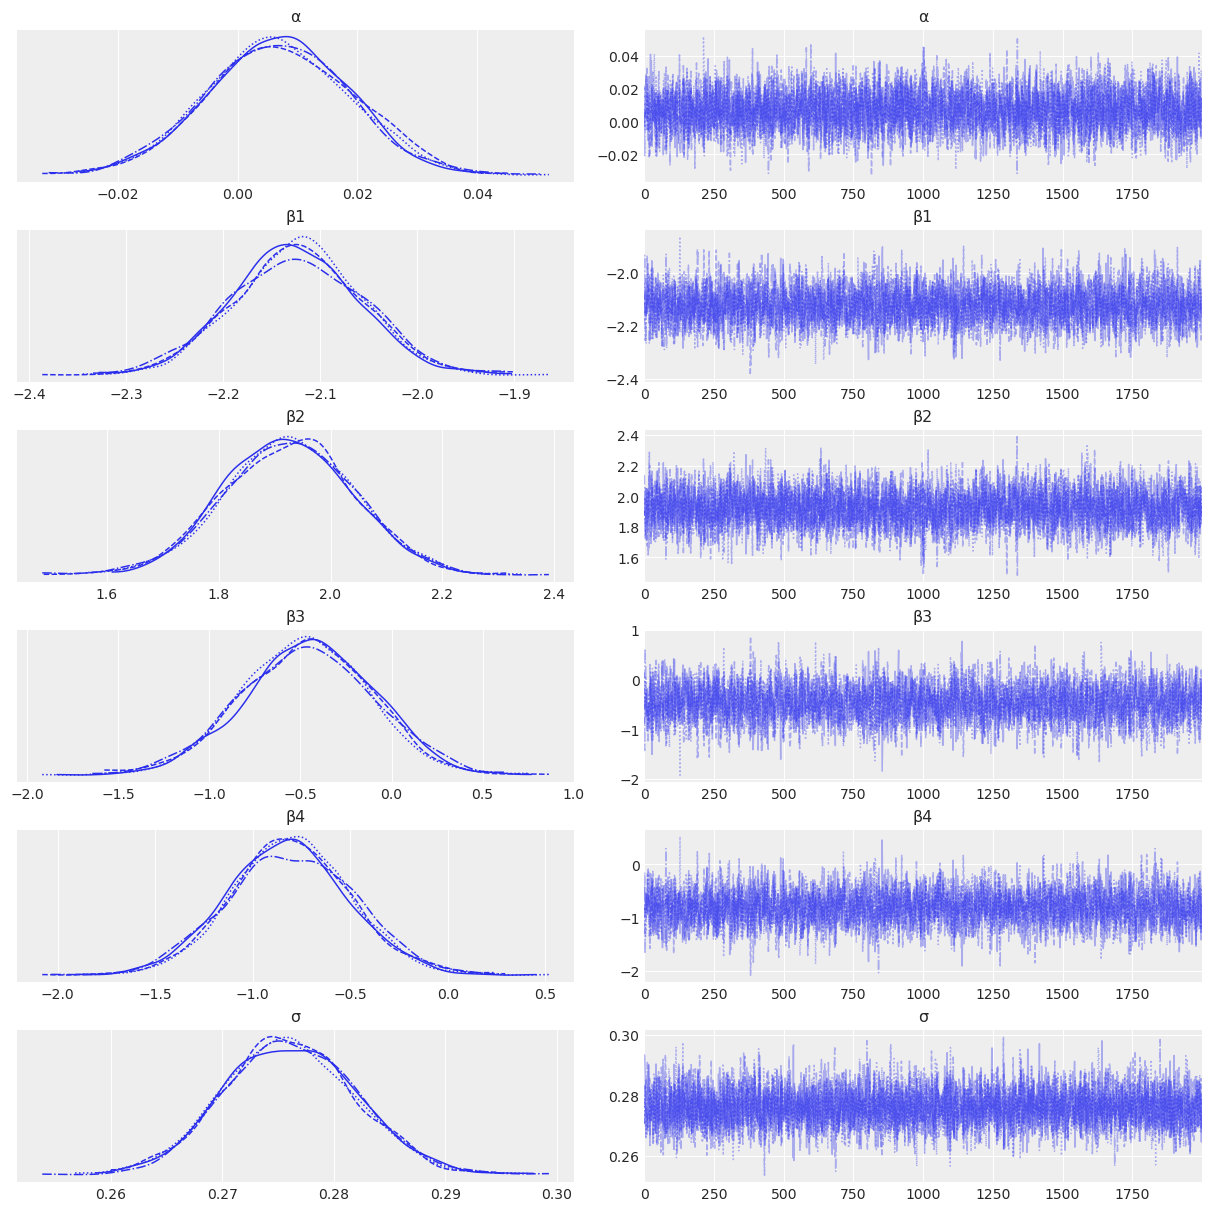

In [109]:
axs = az.plot_trace(idata1);
f_trace1 = pp.gcf()
f_trace1.savefig(img_path /'model1_traceplot.png', dpi=300)
f_trace1.savefig(img_path /'model1_traceplot.pdf', dpi=300)

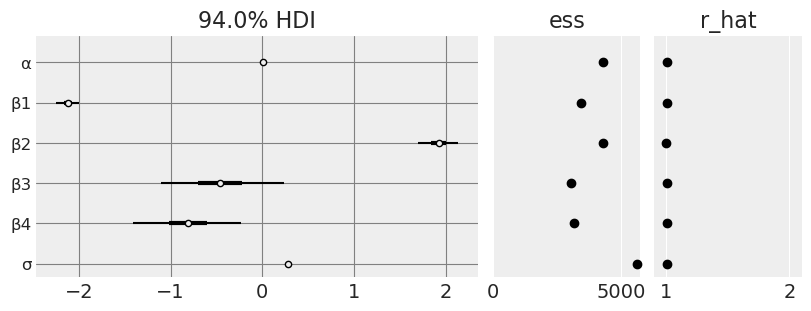

In [68]:
ax = az.plot_forest(
    idata1, var_names=['α'] + [f'β{i}' for i in range(1, 5)] +['σ'], 
    combined=True,
    figsize=(8, 3), colors=['k'], ess=True, r_hat=True
    )[0]
ax.grid(color='gray')
ax.set_yticklabels(ax.get_yticklabels(), fontdict={'size': 12})
f_forest_model1 = pp.gcf()
f_forest_model1.savefig(img_path / 'model1_forest_α_β.png', dpi=300)
f_forest_model1.savefig(img_path / 'model1_forest_α_β.pdf', dpi=300)

Fitting yields clean well mixed traces. There 4 of these for each plot and they essentially look the same. As predicted by the summary table above, there are no divergences. 

So Model 1 sampling looks good. Unless there are issues with any of them I will quickly gloss over the rest of the models.

---
#### Model 2

In [56]:
az.summary(idata2)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
α_μ        0.009  0.249  -0.473    0.465      0.004    0.006    5536.0   
β_μ       -1.553  0.586  -2.544   -0.393      0.008    0.009    6219.0   
α[Rrs411]  0.402  0.033   0.341    0.465      0.000    0.000    7276.0   
α[Rrs443] -0.302  0.150  -0.579   -0.016      0.002    0.002    6579.0   
α[Rrs489]  0.030  0.020  -0.006    0.069      0.000    0.000    8199.0   
α[Rrs510] -0.122  0.022  -0.163   -0.079      0.000    0.000    7304.0   
β[Rrs411] -1.917  0.055  -2.022   -1.814      0.001    0.001    7270.0   
β[Rrs443] -1.081  0.272  -1.623   -0.594      0.003    0.003    6546.0   
β[Rrs489] -2.016  0.129  -2.258   -1.776      0.001    0.001    7788.0   
β[Rrs510] -3.152  0.093  -3.331   -2.979      0.001    0.001    7257.0   
α_σ        0.452  0.273   0.126    0.914      0.004    0.008    5094.0   
β_σ        1.148  0.546   0.434    2.209      0.008    0.010    5830.0   
σ          0.268  0.006   0.257    0.279      0.000    0.000    9211.0   

           ess_tail  r_hat  
α_μ          3457.0    1.0  
β_μ          4894.0    1.0  
α[Rrs411]    5693.0    1.0  
α[Rrs443]    5460.0    1.0  
α[Rrs489]    5994.0    1.0  
α[Rrs510]    5316.0    1.0  
β[Rrs411]    5259.0    1.0  
β[Rrs443]    5535.0    1.0  
β[Rrs489]    6123.0    1.0  
β[Rrs510]    5378.0    1.0  
α_σ          4423.0    1.0  
β_σ          5369.0    1.0  
σ            4966.0    1.0

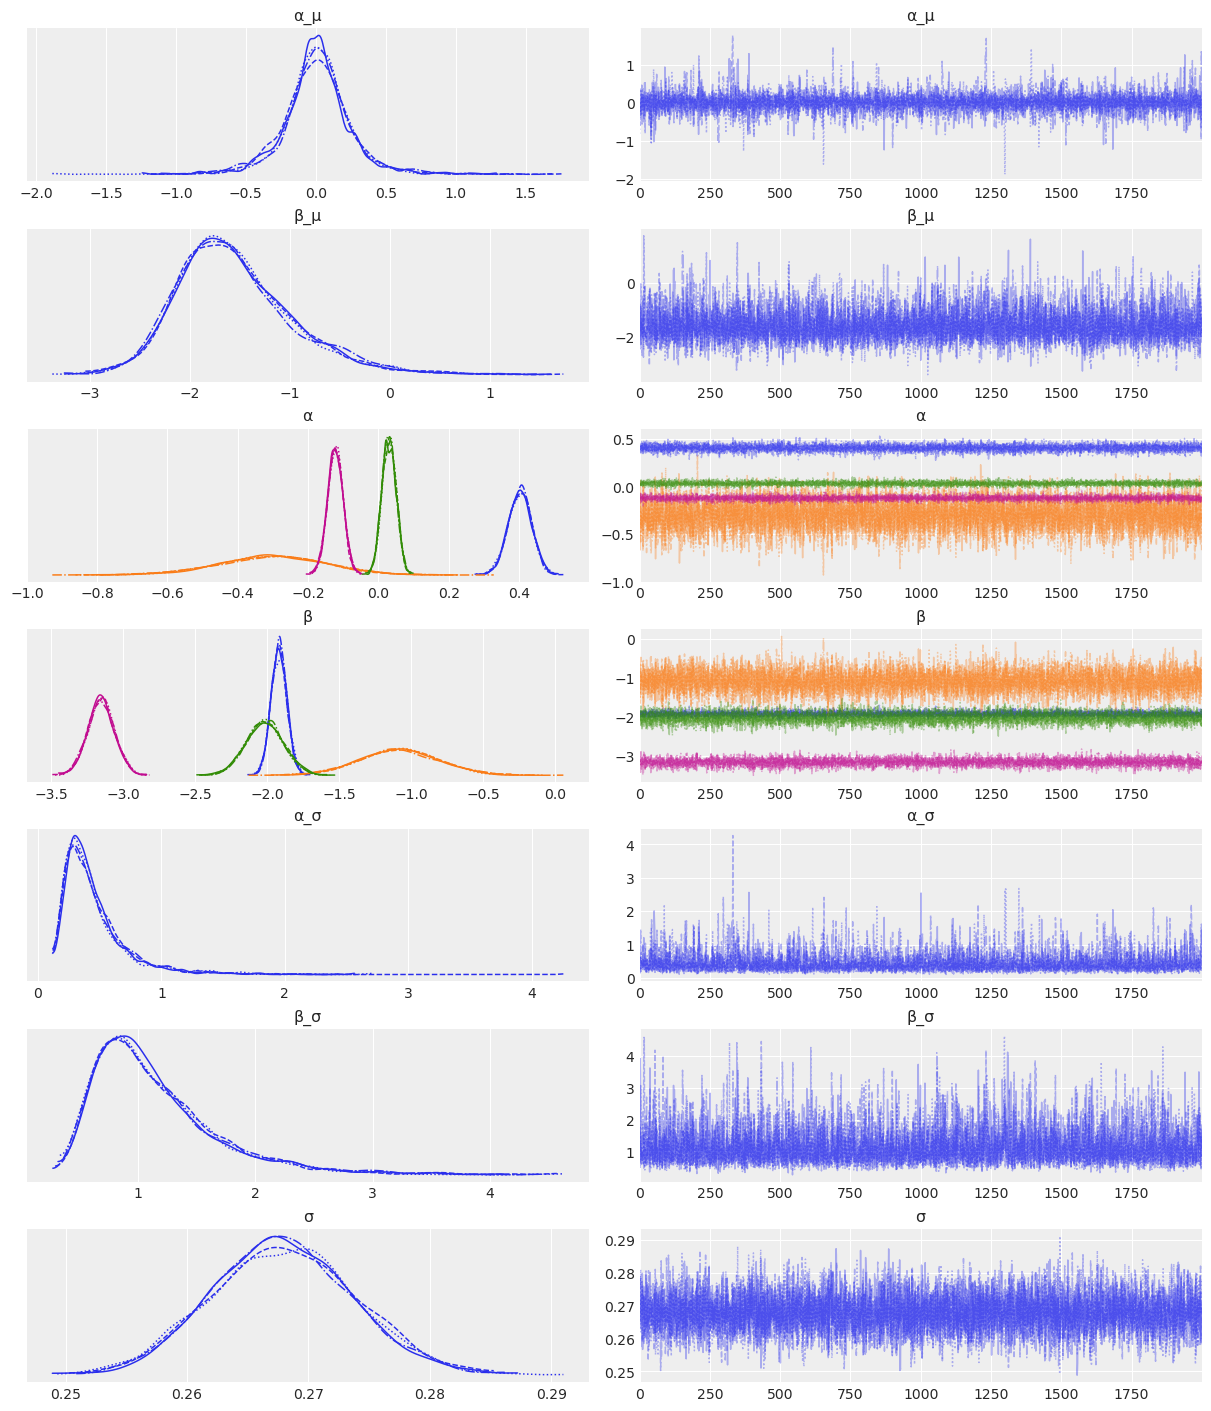

In [72]:
axs = az.plot_trace(idata2);
f_trace2 = pp.gcf()
f_trace2.savefig(img_path /'model2_traceplot.png', dpi=300)
f_trace2.savefig(img_path /'model2_traceplot.pdf', dpi=300)

No particular isses noted with model 2

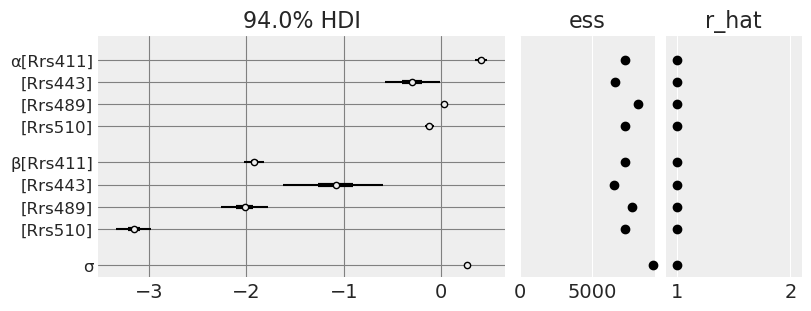

In [63]:
ax = az.plot_forest(
    idata2, var_names=['α','β', 'σ'], 
    combined=True,
    figsize=(8, 3),
    colors=['k'], ess=True, r_hat=True, #kind='ridgeplot', ridgeplot_alpha=0.5
    )[0]
ax.grid(color='gray')
ax.set_yticklabels(ax.get_yticklabels(), fontdict={'size': 12})
f_forest_model2 = pp.gcf()
f_forest_model2.savefig(img_path / 'model2_forest_α_β.png', dpi=300)

In [ ]:
plot_forest(idata2, model_name='model2', var_names=['α', 'β', 'σ'], save_suffix='forest_α_β')

---
#### Model 3

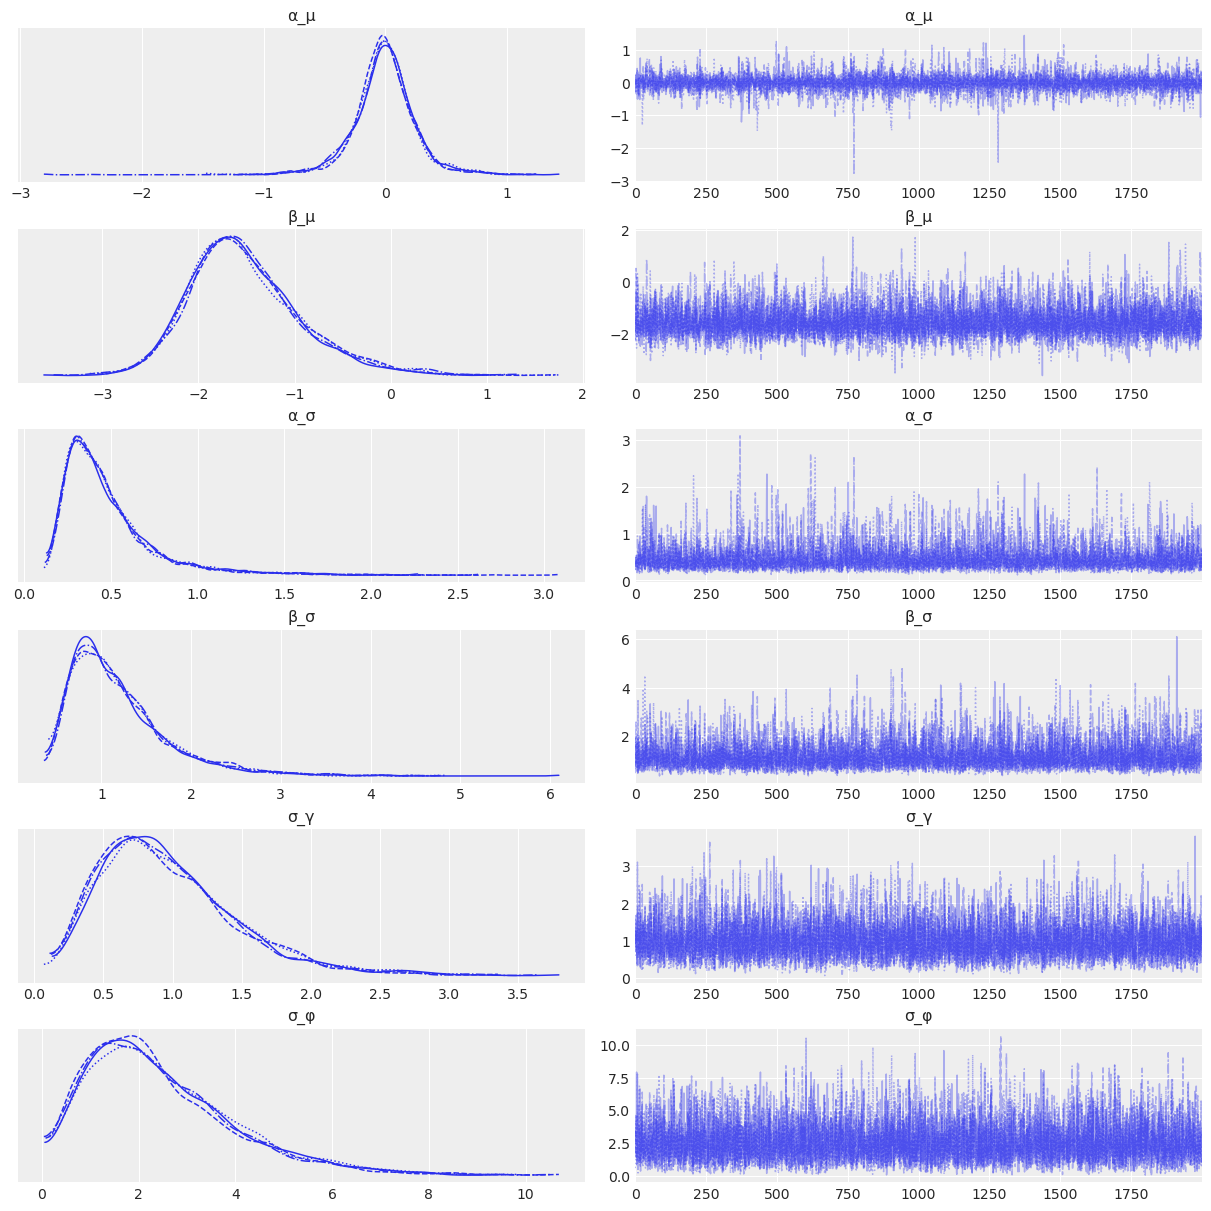

In [118]:
plot_trace(idata3, model_name='model3_hyperpriors', var_names=['_'], filter_vars='like')

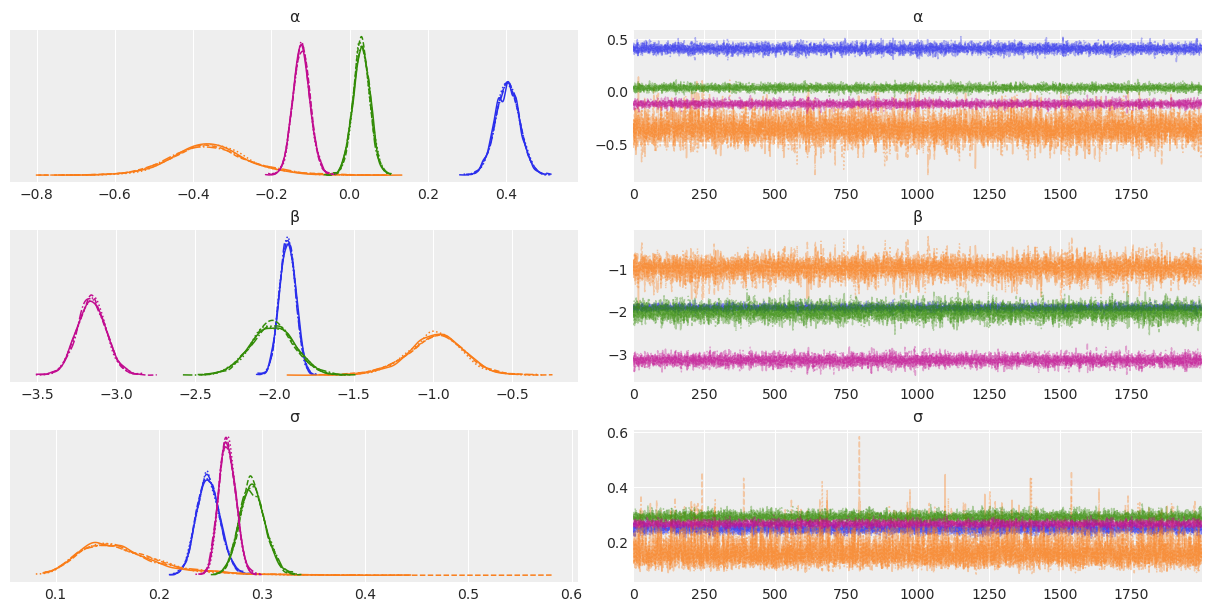

In [119]:
plot_trace(idata3, model_name='model3_priors', var_names=['~_'], filter_vars='like')

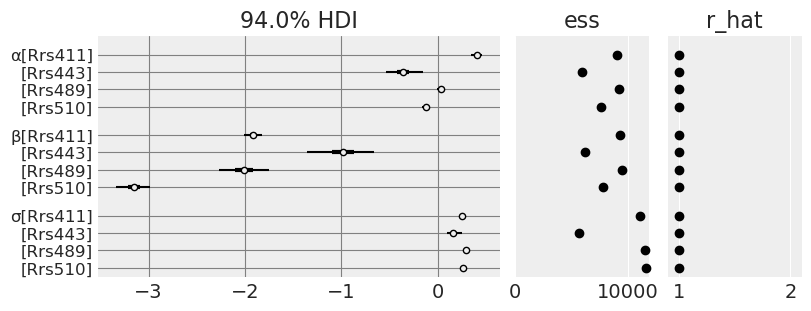

In [76]:
plot_forest(idata3, model_name='model3', var_names=['α', 'β', 'σ'])

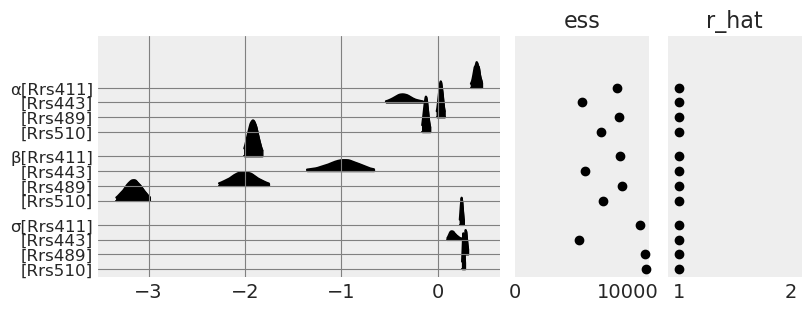

In [142]:
plot_forest(idata3, model_name='model3_ridge', var_names=['α', 'β', 'σ'], kind='ridgeplot')

---
#### Model 4

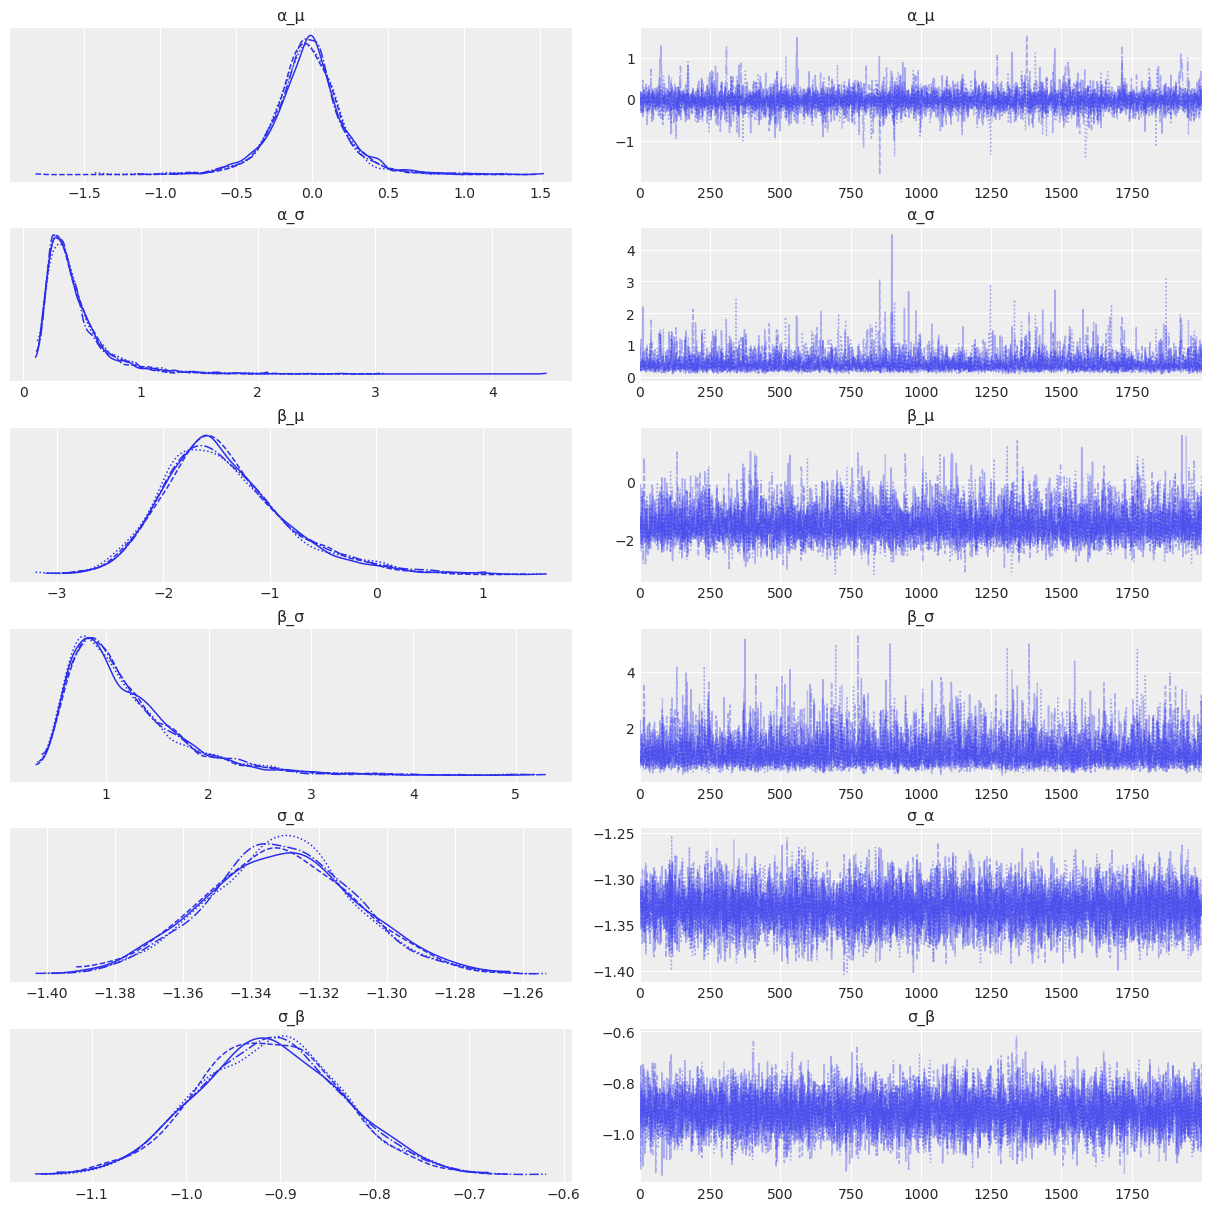

In [140]:
plot_trace(idata4, model_name='model4_hyperpriors', var_names=['α_μ', 'α_σ', 'β_μ', 'β_σ', 'σ_α', 'σ_β'])

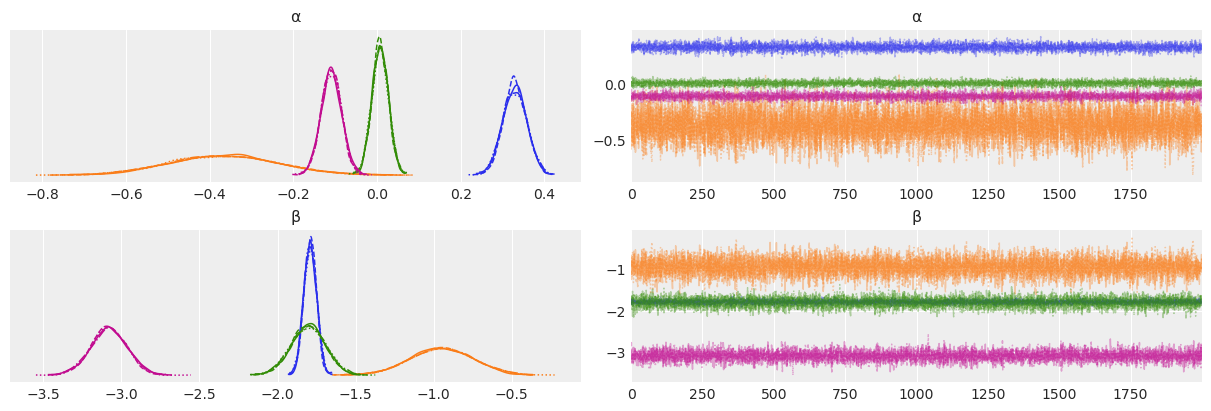

In [122]:
plot_trace(idata4, model_name='model4_priors', var_names=['~_', '~σ'], filter_vars='like')

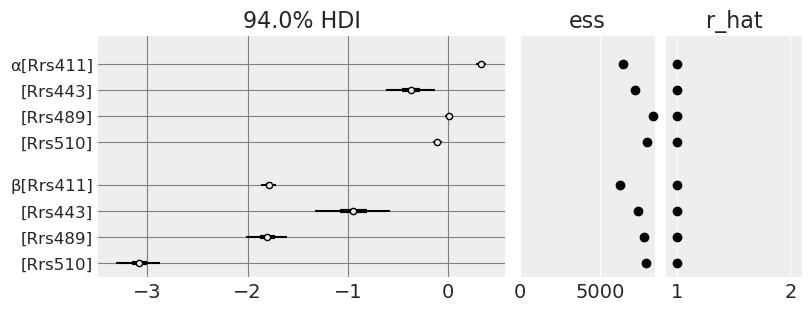

In [78]:
plot_forest(idata4, model_name='model4', var_names=['α', 'β'], save_suffix='forest_α_β')

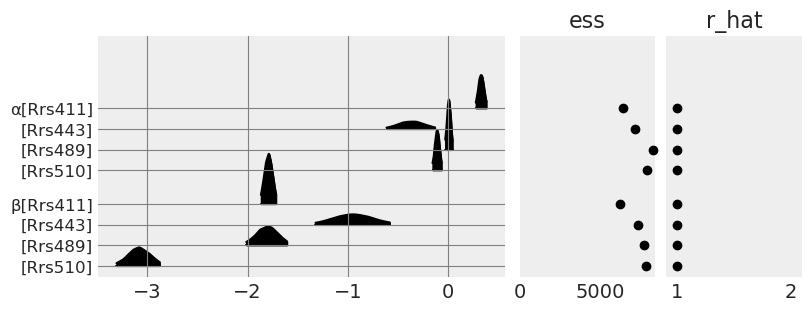

In [141]:
plot_forest(idata4, model_name='model4_ridge', var_names=['α', 'β'], save_suffix='forest_α_β', kind='ridgeplot')

---
#### Model 5

In [79]:
az.summary(idata5)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
α_μ       -0.034  0.238  -0.511    0.374      0.004    0.008    4752.0   
β_μ       -1.406  0.580  -2.405   -0.269      0.007    0.008    8422.0   
σ_α_μ     -1.119  0.259  -1.627   -0.632      0.004    0.006    5513.0   
σ_β_μ     -0.984  0.487  -1.885   -0.017      0.008    0.008    4376.0   
α[Rrs411]  0.326  0.031   0.270    0.387      0.000    0.000    5978.0   
...          ...    ...     ...      ...        ...      ...       ...   
σ[1077]    0.266  0.008   0.251    0.282      0.000    0.000    9225.0   
σ[1078]    0.402  0.035   0.340    0.468      0.000    0.000    5031.0   
σ[1079]    0.282  0.012   0.260    0.304      0.000    0.000   11687.0   
σ[1080]    0.269  0.009   0.253    0.285      0.000    0.000    9317.0   
σ[1081]    0.278  0.011   0.260    0.300      0.000    0.000    8584.0   

           ess_tail  r_hat  
α_μ          3524.0    1.0  
β_μ          4899.0    1.0  
σ_α_μ        3804.0    1.0  
σ_β_μ        3583.0    1.0  
α[Rrs411]    5782.0    1.0  
...             ...    ...  
σ[1077]      4961.0    1.0  
σ[1078]      5371.0    1.0  
σ[1079]      6566.0    1.0  
σ[1080]      4755.0    1.0  
σ[1081]      5310.0    1.0  

[1106 rows x 9 columns]

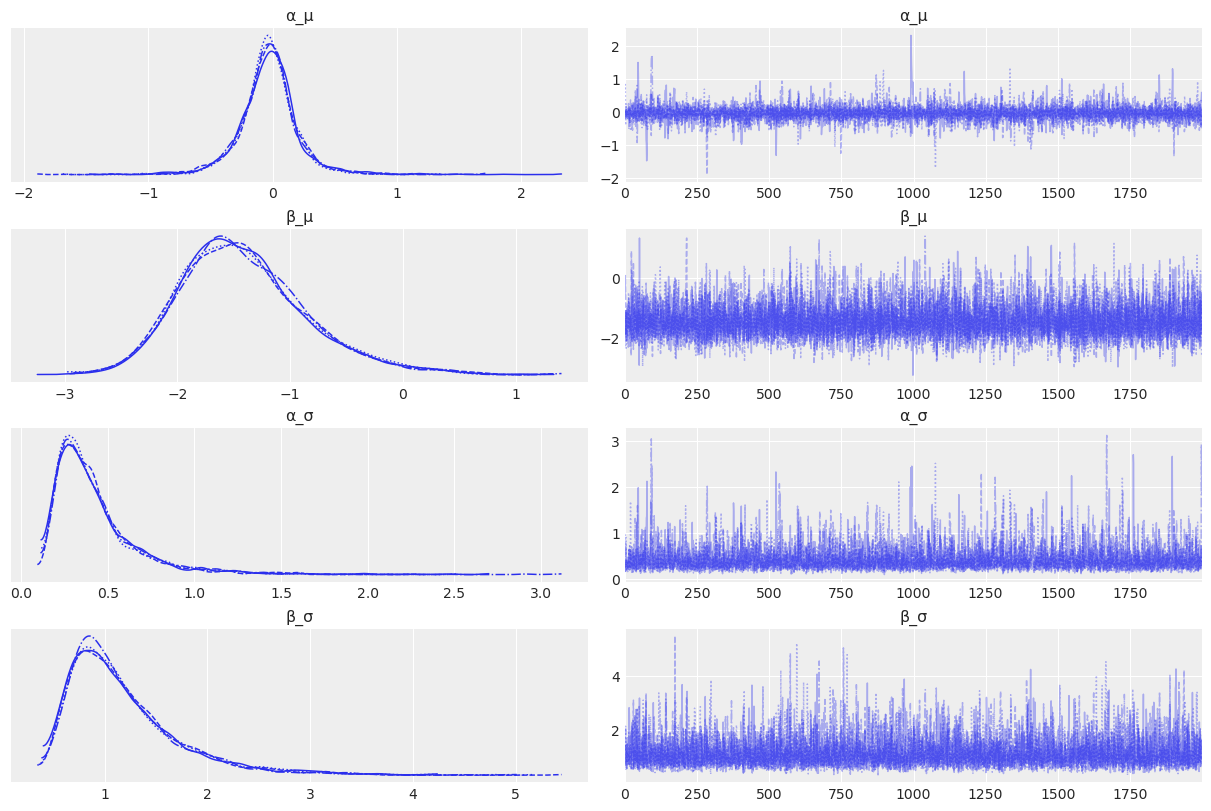

In [134]:
plot_trace(idata5, model_name='model5_hyper_mean', var_names=['^[α, β]_[μ, σ]$'], filter_vars='regex')

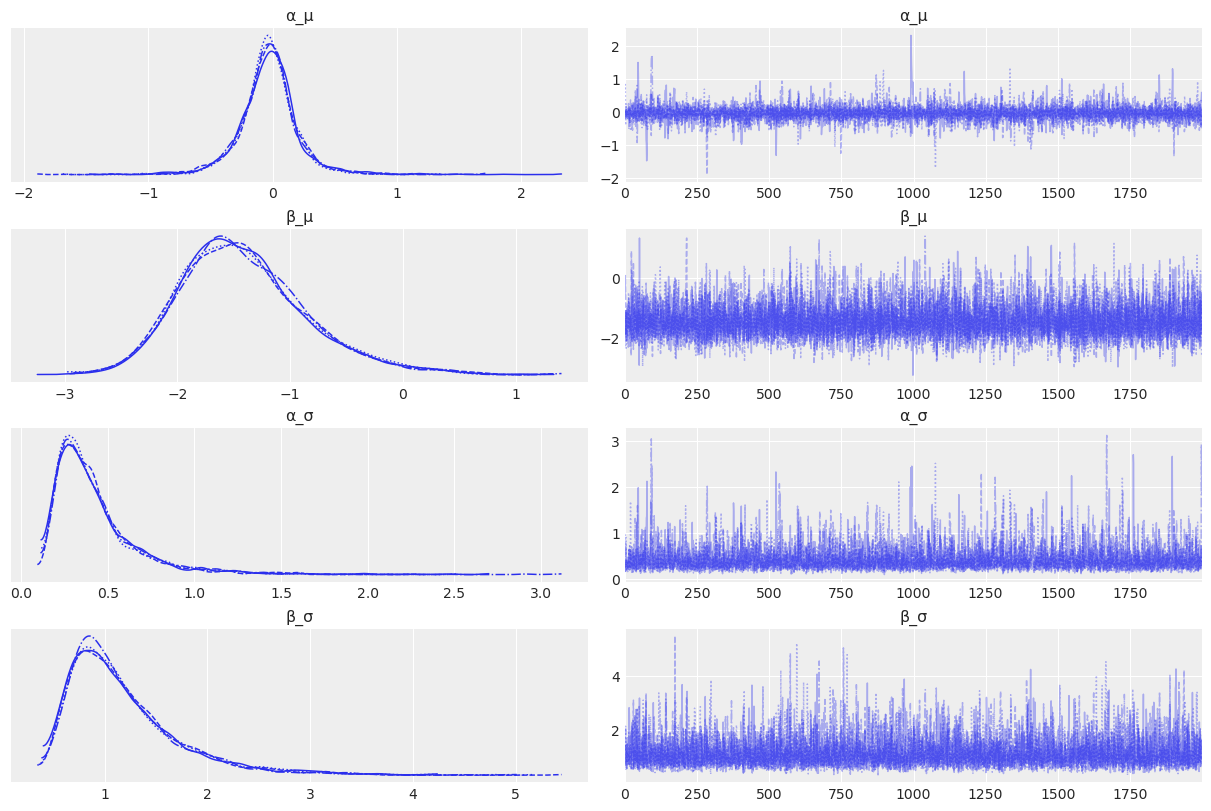

In [132]:
plot_trace(idata5, model_name='model5_priors', var_names=['^[α, β]_[σ, μ]$'], filter_vars='regex')

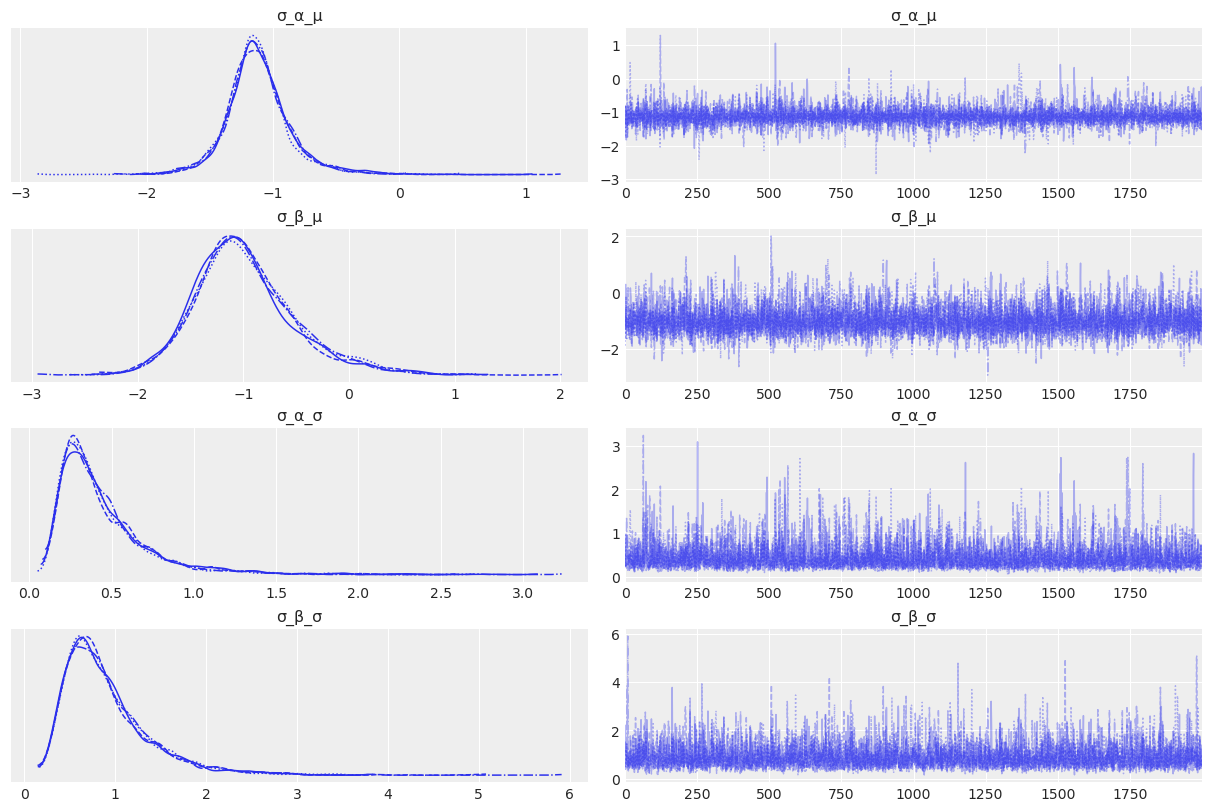

In [136]:
plot_trace(idata5, model_name='model5_hyper_variance', var_names=['^[σ]_[β, α]_'], filter_vars='regex')

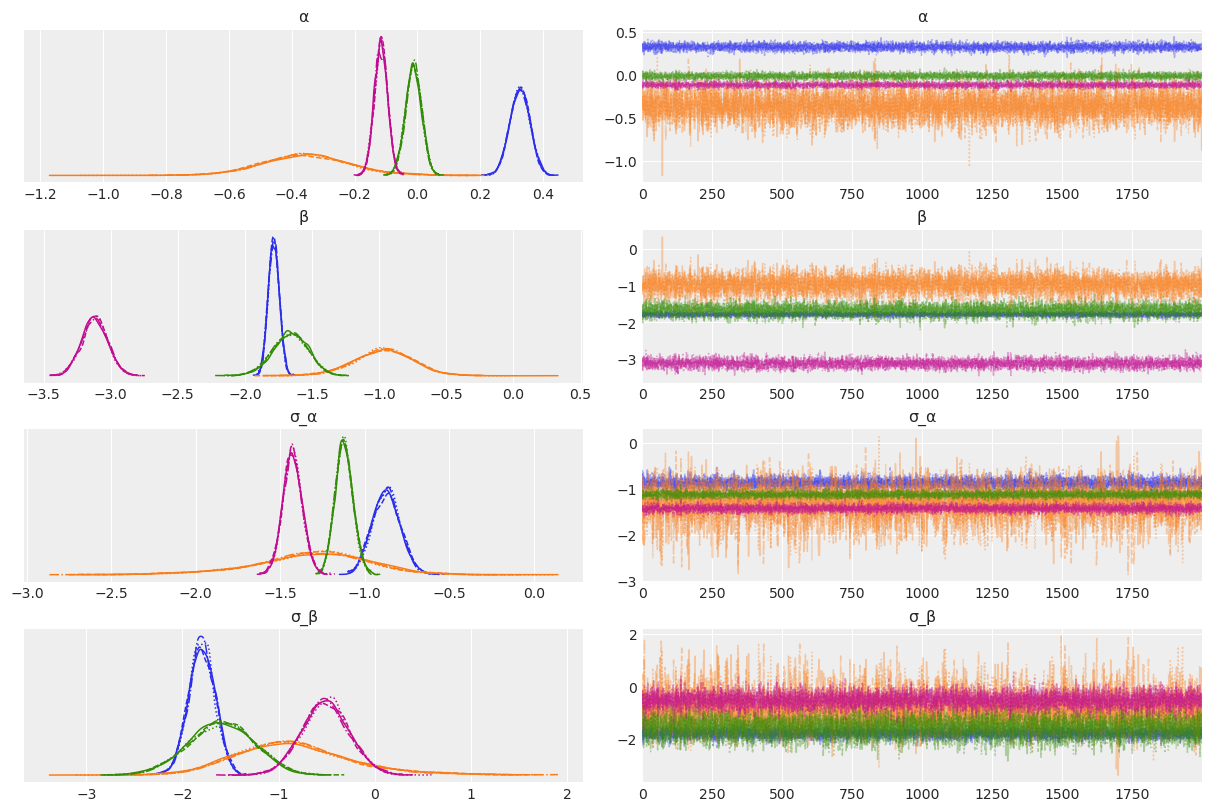

In [139]:
plot_trace(
    idata5, model_name='model5_priors', var_names=['α', 'β', 'σ_α', 'σ_β'], filter_vars=None)

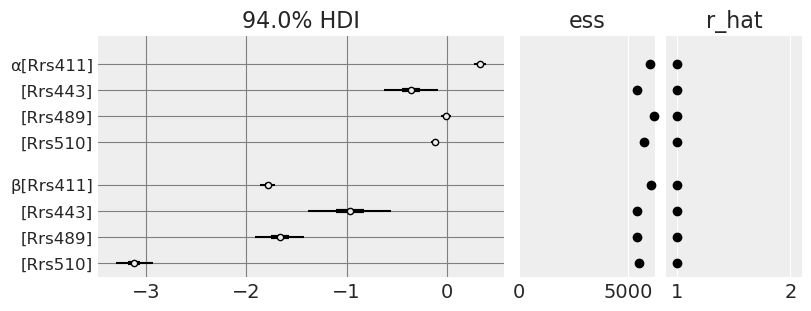

In [81]:
plot_forest(idata5, model_name='model5', var_names=['α', 'β'], save_suffix='forest_α_β')

Model 5 doesn't seem to have convergence issues or indeed any fitting issues.

---

### Step 5 Comparing Parameter Posteriors where Relevant
To further build insight on what models are 

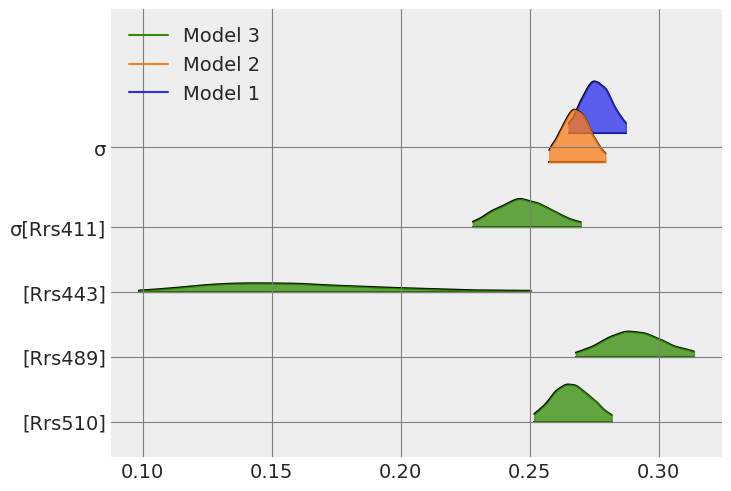

In [143]:
f, ax = pp.subplots()
az.plot_forest(
    [   
        idata1, 
        idata2,
        idata3,

    ], 
    model_names=[
        'Model 1', 'Model 2', 'Model 3'
        ],
    var_names='σ', combined=True, ax=ax, kind='ridgeplot', ridgeplot_alpha=0.75)
ax.grid(visible=True, color='gray')
f.savefig(img_path/'post_comp_sigma_1_2_3.png', dpi=300)

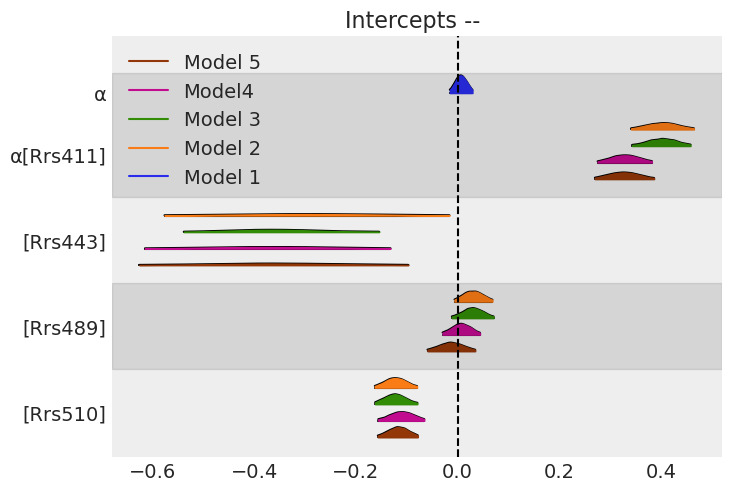

In [98]:
f, ax = pp.subplots()
az.plot_forest(
    [idata1, idata2, idata3, idata4, idata5], 
    model_names=['Model 1', 'Model 2', 'Model 3', 'Model4', 'Model 5'],
    var_names='α', combined=True, ax=ax, kind='ridgeplot')
ax.set_title('Intercepts -- ' + ax.get_title())
ax.axvline(0, ls='--', color='k')
f.savefig(img_path / 'post_comp_intercepts_all_models.png', dpi=300)


---

### STEP 5 - Posterior Predictive Checks
Posterior predictive checks simulates data from the trained model, i.e. , $\hat{y}$ conditioned on $y$, and the parameter's posterior distribution, the idea being to look for systematic discrepancies between $\hat{y}$ and $y$: 
$$p({\hat{y}} | y) = \int p({\hat{y}} | θ ) \, p(θ| y) \, dθ$$
This takes two forms. The first is *in-sample prediction*, sometimes referred to as posterior retrodictive checks, uses the same data that the model was fitted on. This is a recommended sanity step for diagnosing post-sampling modeling issues.
The second form of Posteerior Predictive Checks is out-of-sample prediction, the goal of which is to test the model for generalization, that is predictive skill on data not previously seen. For this step I use data from  Valente *et al. (2022). I isolated a subset identified as 'seabass', which I then cleaned, preprocessed and transformed as I did for the training data.

In each case I sample in- and out-of-sample posterior predictives. I then plot each group of samples in a number of ways to make sure the model works as expected. I will also use these findings to inform model comparison and selection in ***STEP 6***. 

In [41]:
oos_path = project_path / 'data' / '05_out_of_sample'
d_oos = pd.read_parquet(oos_path / 'df_sbs_oos_redux.pqt')

In [42]:
d_oos.info()

<class 'pandas.core.frame.DataFrame'>
Index: 53 entries, 4977 to 68675
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   log_MBR    53 non-null     float64
 1   MBR_flag   53 non-null     object 
 2   log_chl    53 non-null     float64
 3   hplc_flag  53 non-null     object 
dtypes: float64(2), object(2)
memory usage: 2.1+ KB


#### Model 1

In [82]:
with model1:
    idata1.extend(pm.sample_posterior_predictive(idata1))
    pm.compute_log_likelihood(idata1, extend_inferencedata=True)

Sampling: [likelihood]


Output()

Output()

In [83]:
with model2:
    idata2.extend(pm.sample_posterior_predictive(idata2))
    pm.compute_log_likelihood(idata2, extend_inferencedata=True)

Sampling: [likelihood]


Output()

Output()

In [ ]:
with model3:
    idata3.extend(pm.sample_posterior_predictive(idata3))
    pm.compute_log_likelihood(idata3, extend_inferencedata=True)

Sampling: [likelihood]


Output()

Output()

In [85]:
with model4:
    idata4.extend(pm.sample_posterior_predictive(idata4))
    pm.compute_log_likelihood(idata4, extend_inferencedata=True)

Sampling: [likelihood]


Output()

Output()

In [86]:
with model5:
    idata5.extend(pm.sample_posterior_predictive(idata5))
    pm.compute_log_likelihood(idata5, extend_inferencedata=True)

Sampling: [likelihood]


Output()

Output()

The CDF plot above shows simulated chlorophyll output (blue), simulation mean (orange), and for comparison the set of observations (black). The inflections seem reasonably well captured by the model. The data is nearly equally divided at the $1mg m^{-3}$ chlorophyll mark. The black line is at the edge of the blue envolope. at values under  $0.1mg m^{-3}$, $1mg m^{-3}$, and near $10mg m^{-3}$. Unlike the 2 others, this finding at the $1mg m^{-3}$ is surprising given the plot suggest a good amount of data there. Looking at the corresponding distribution of these plots may be informative.

---
### Model Evaluation Plots

In [155]:
def make_evaluation_plot(idata):
    f = pp.figure(figsize=(10, 6))
    ax2 = f.add_subplot(222)
    az.plot_ppc(idata, colors=PPC_COLORS, ax=ax2)
    ax2.set_xlabel('log(Chl-a)')
    ax1 = f.add_subplot(221)
    az.plot_ppc(idata, group='prior', observed=True, colors=PPC_COLORS, ax=ax1)
    ax1.set_ylim(ax2.get_ylim())
    ax1.set_xlabel('log(Chl-a)')
    ax3 = f.add_subplot(223)
    az.plot_loo_pit(idata, y='likelihood', ax=ax3)
    ax3.set_xlabel(r'$\text{PIT}(y_i|y_{-i})$')
    #ax3.set_yticklabels([])
    ax3.axhline(y=1, ls='--', color='k')
    ax4 = f.add_subplot(224)
    az.plot_loo_pit(idata, y='likelihood', ax=ax4, ecdf=True)
    ax4.set_xlabel(r'$\text{PIT}(y_i|y_{-i})$')
    #ax4.set_yticklabels([])
    ax4.axhline(y=0, ls='--', color='k')
    f.tight_layout()
    return f


/var/folders/c9/p_x94m2j357984db558g2n9m0000gn/T/ipykernel_53253/1227211998.py:20: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  f.tight_layout()
/var/folders/c9/p_x94m2j357984db558g2n9m0000gn/T/ipykernel_53253/1227211998.py:20: UserWarning: The figure layout has changed to tight
  f.tight_layout()
/var/folders/c9/p_x94m2j357984db558g2n9m0000gn/T/ipykernel_53253/308488488.py:2: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  f.savefig(img_path / 'model1_evaluation.pdf', dpi=300)
/var/folders/c9/p_x94m2j357984db558g2n9m0000gn/T/ipykernel_53253/308488488.py:3: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  f.savefig(img_path / 'model1_evaluation.png', dpi=300)
/Users/erdemkarakoylu/miniconda3/envs/pymc_base/lib/python3.12/site-packages/IPython/core/events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)


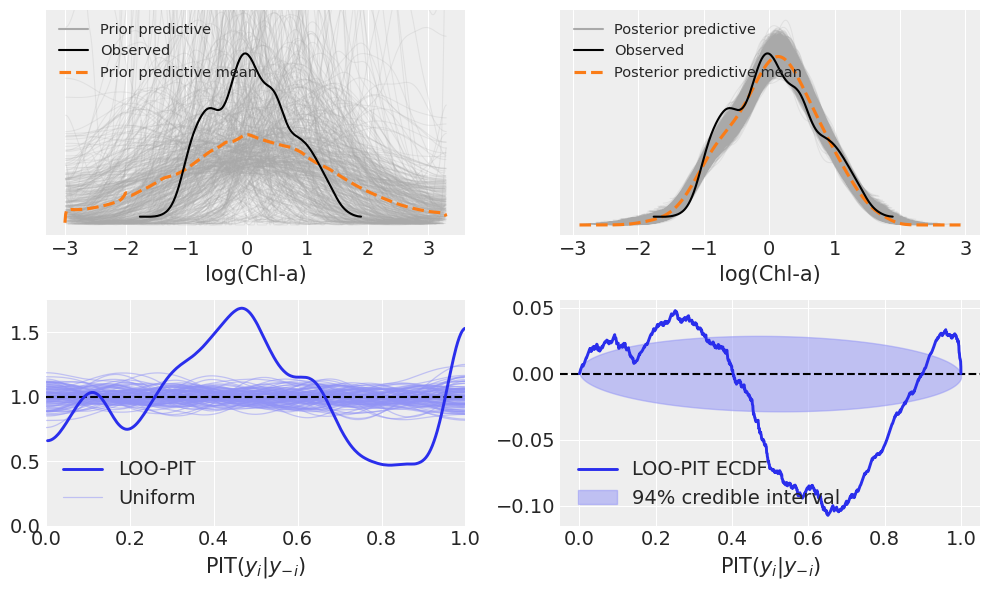

In [156]:
f = make_evaluation_plot(idata1)
f.savefig(img_path / 'model1_evaluation.pdf', dpi=300)
f.savefig(img_path / 'model1_evaluation.png', dpi=300)

/var/folders/c9/p_x94m2j357984db558g2n9m0000gn/T/ipykernel_26993/1227211998.py:20: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  f.tight_layout()
/var/folders/c9/p_x94m2j357984db558g2n9m0000gn/T/ipykernel_26993/1227211998.py:20: UserWarning: The figure layout has changed to tight
  f.tight_layout()
/Users/erdemkarakoylu/miniconda3/envs/pymc_base/lib/python3.12/site-packages/IPython/core/events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/Users/erdemkarakoylu/miniconda3/envs/pymc_base/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


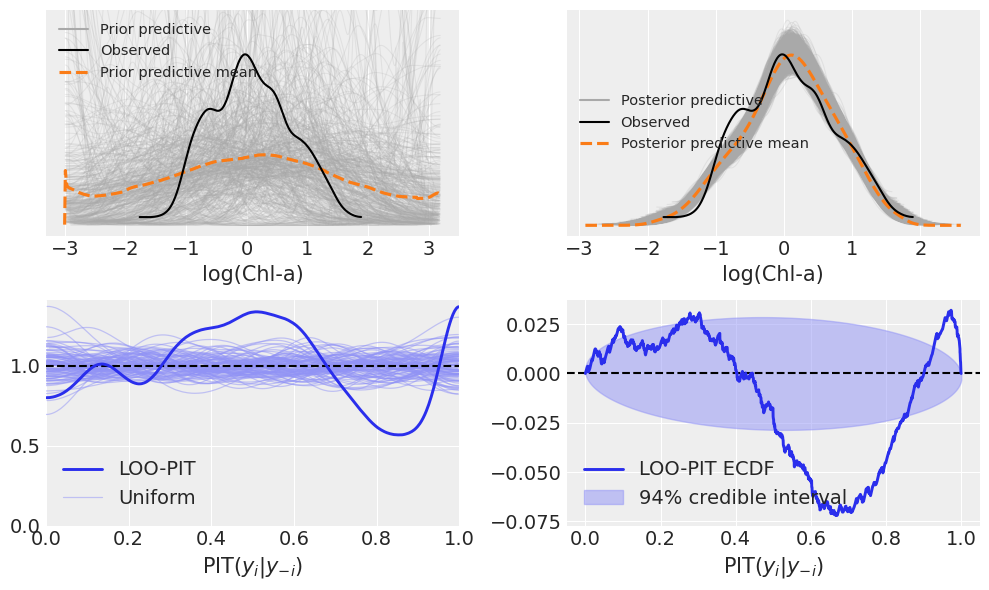

In [ ]:
f2 = make_evaluation_plot(idata2)
f2.savefig(img_path / 'model2_evaluation.pdf', dpi=300)
f2.savefig(img_path / 'model2_evaluation.png', dpi=300)

/var/folders/c9/p_x94m2j357984db558g2n9m0000gn/T/ipykernel_53253/1227211998.py:20: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  f.tight_layout()
/var/folders/c9/p_x94m2j357984db558g2n9m0000gn/T/ipykernel_53253/1227211998.py:20: UserWarning: The figure layout has changed to tight
  f.tight_layout()
/var/folders/c9/p_x94m2j357984db558g2n9m0000gn/T/ipykernel_53253/2160486857.py:2: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  f3.savefig(img_path / 'model3_evaluation.pdf', dpi=300)
/var/folders/c9/p_x94m2j357984db558g2n9m0000gn/T/ipykernel_53253/2160486857.py:3: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  f3.savefig(img_path / 'model3_evaluation.png', dpi=300)
/Users/erdemkarakoylu/miniconda3/envs/pymc_base/lib/python3.12/site-packages/IPython/core/events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwar

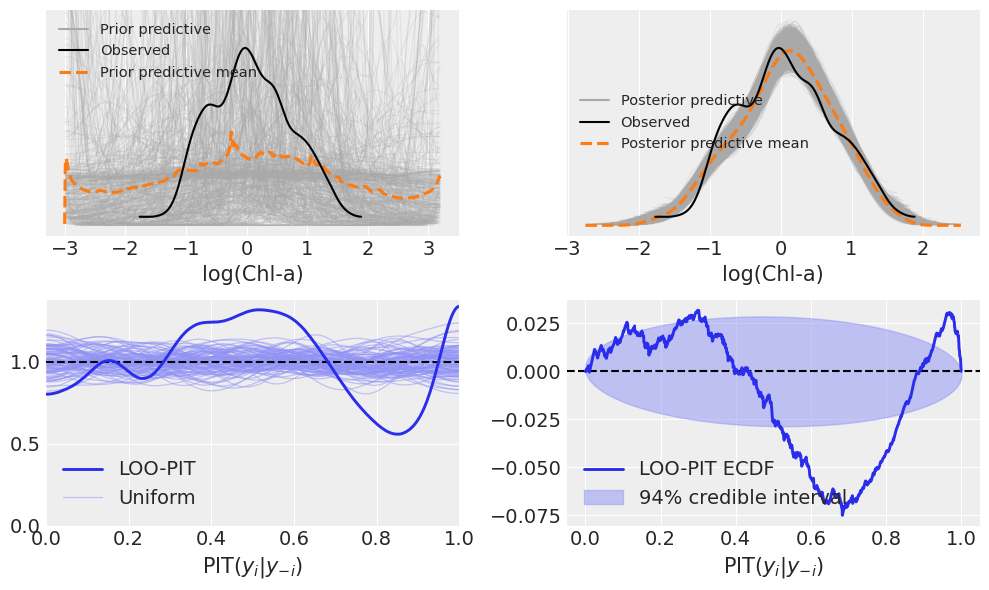

In [89]:
f3 = make_evaluation_plot(idata3)
f3.savefig(img_path / 'model3_evaluation.pdf', dpi=300)
f3.savefig(img_path / 'model3_evaluation.png', dpi=300)

/var/folders/c9/p_x94m2j357984db558g2n9m0000gn/T/ipykernel_53253/1227211998.py:20: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  f.tight_layout()
/var/folders/c9/p_x94m2j357984db558g2n9m0000gn/T/ipykernel_53253/1227211998.py:20: UserWarning: The figure layout has changed to tight
  f.tight_layout()
/var/folders/c9/p_x94m2j357984db558g2n9m0000gn/T/ipykernel_53253/1362164923.py:2: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  f4.savefig(img_path / 'model4_evaluation.pdf', dpi=300)
/var/folders/c9/p_x94m2j357984db558g2n9m0000gn/T/ipykernel_53253/1362164923.py:3: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  f4.savefig(img_path / 'model4_evaluation.png', dpi=300)
/Users/erdemkarakoylu/miniconda3/envs/pymc_base/lib/python3.12/site-packages/IPython/core/events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwar

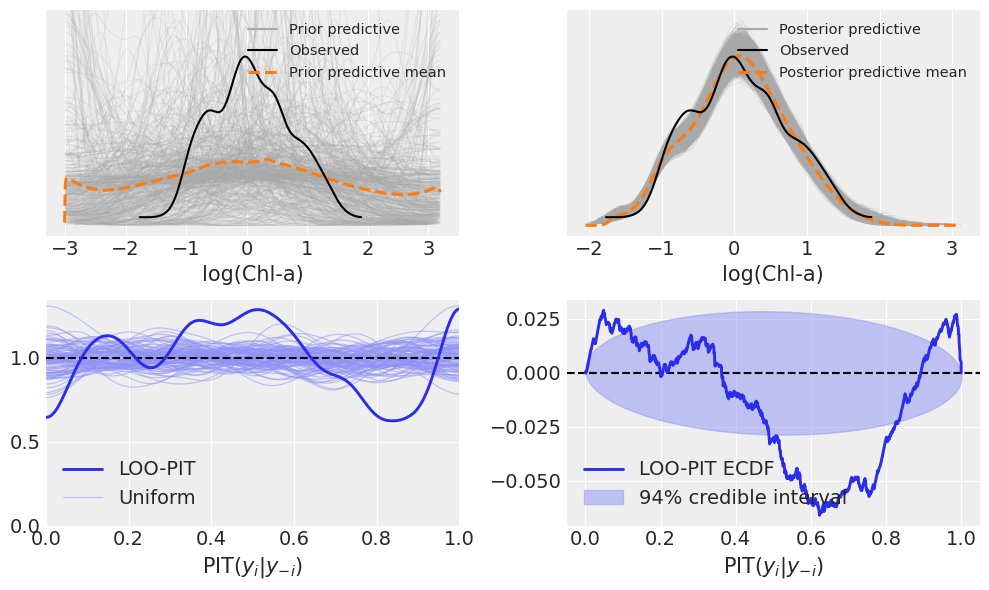

In [90]:
f4 = make_evaluation_plot(idata4)
f4.savefig(img_path / 'model4_evaluation.pdf', dpi=300)
f4.savefig(img_path / 'model4_evaluation.png', dpi=300)

/var/folders/c9/p_x94m2j357984db558g2n9m0000gn/T/ipykernel_26993/1227211998.py:20: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  f.tight_layout()
/var/folders/c9/p_x94m2j357984db558g2n9m0000gn/T/ipykernel_26993/1227211998.py:20: UserWarning: The figure layout has changed to tight
  f.tight_layout()
/var/folders/c9/p_x94m2j357984db558g2n9m0000gn/T/ipykernel_26993/1387066809.py:2: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  f5.savefig(img_path / 'model5_evaluation.pdf', dpi=300)
/var/folders/c9/p_x94m2j357984db558g2n9m0000gn/T/ipykernel_26993/1387066809.py:3: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  f5.savefig(img_path / 'model5_evaluation.png', dpi=300)
/Users/erdemkarakoylu/miniconda3/envs/pymc_base/lib/python3.12/site-packages/IPython/core/events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwar

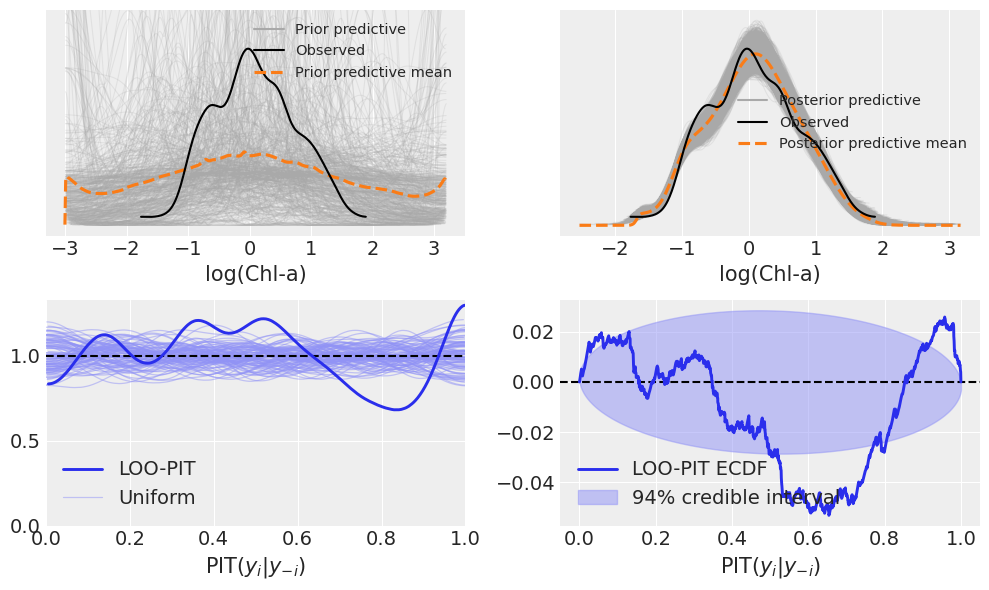

In [58]:
f5 = make_evaluation_plot(idata5)
f5.savefig(img_path / 'model5_evaluation.pdf', dpi=300)
f5.savefig(img_path / 'model5_evaluation.png', dpi=300)

---
### In-Sample/Out-of-Sample Predictive Coverage Plots

In [91]:
# Create coordinates for modeling with PyMC
# assign features and target to

mbr_type_idx, mbr_type = df_training.MBR_flag.factorize(sort=True)
chl_type_idx, chl_type = df_training.hplc_flag.factorize(sort=True)
λ_Rrs_idx, λ_Rrs = df_training.filter(like='Rrs').columns.factorize(sort=True)
COORDS = {
    'MBR_numerator': mbr_type,
    'chl_type': chl_type,
    'obs_idx': df_training.index,
    'λ_Rrs': λ_Rrs
}

#### Load OOS data:

In [93]:
d_oos = pd.read_parquet(data_path.parent / '05_out_of_sample' / 'df_sbs_oos_redux.pqt')

In [62]:
d_oos.head()

log_MBR MBR_flag   log_chl hplc_flag
idx                                        
4977  0.553699   Rrs411 -0.863597      fluo
4979  0.639028   Rrs411 -0.931072      fluo
4992  0.320401   Rrs489 -0.720789      fluo
5002  0.007412   Rrs489 -0.849244      fluo
5026 -0.165225   Rrs510  0.141418      fluo

#### Run Analysis and Plotting

Sampling: [likelihood]


Output()

/var/folders/c9/p_x94m2j357984db558g2n9m0000gn/T/ipykernel_26993/2165081204.py:52: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


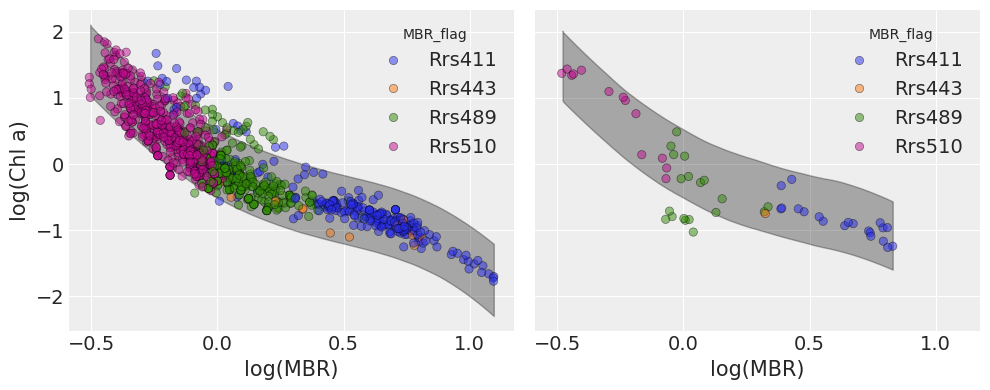

In [113]:
f_cov1, axs_cov1 = plot_regression_hdi_2panel(
    idata1, model1, df_train=df_training, df_test=d_oos)

Interpretation: Above, I use a $94\%$ Highest Density Interval (HDI - shaded region) to illustrate the probability of chlorophyll given a log(MBR) input. E.g. for $\text{log(MBR)}=0$ there is a $94\%$ chance that $log(\text{Chl a}) \in [-0.6, 0.5]$ (conditioned on the model and the data), which corresponds to an interval of approx $[0.25, 3.2]\ mg\ m^{-3}$. This is a large range, 1 order of magnitude. Nevertheless, a number of things can be improved upon. E.g. trying to make the model complex enough by using a polynomial expression limits the flexibility of the model, and the slopes of the higher order terms are neither informative, nor interpretable.

In [114]:
f_cov1.savefig(img_path / 'model1_predictive_coverage.pdf', dpi=300)

Sampling: [likelihood]


Output()

/var/folders/c9/p_x94m2j357984db558g2n9m0000gn/T/ipykernel_26993/2165081204.py:52: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


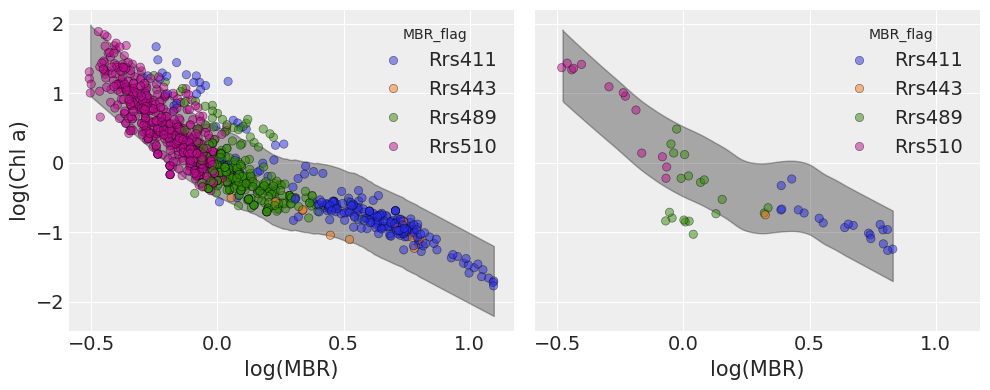

In [115]:
f_cov2, axs_cov2 = plot_regression_hdi_2panel(
    idata2, model2, df_train=df_training, df_test=d_oos)

In [116]:
f_cov2.savefig(img_path / 'model2_predictive_coverage.pdf', dpi=300)

Sampling: [likelihood]


Output()

/var/folders/c9/p_x94m2j357984db558g2n9m0000gn/T/ipykernel_53253/2165081204.py:52: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


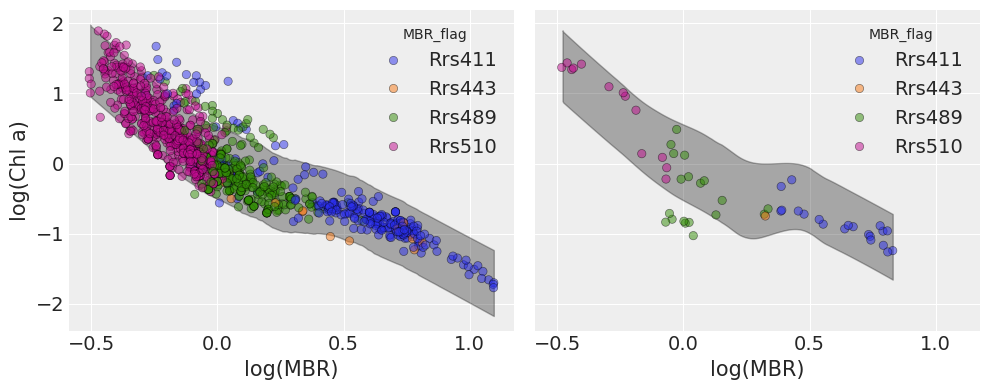

In [94]:
f_cov3, axs_cov3 = plot_regression_hdi_2panel(
    idata3, model3, df_train=df_training, df_test=d_oos)

In [95]:
f_cov3.savefig(img_path / 'model3_predictive_coverage.pdf', dpi=300)

Sampling: [likelihood]


Output()

/var/folders/c9/p_x94m2j357984db558g2n9m0000gn/T/ipykernel_53253/2165081204.py:52: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


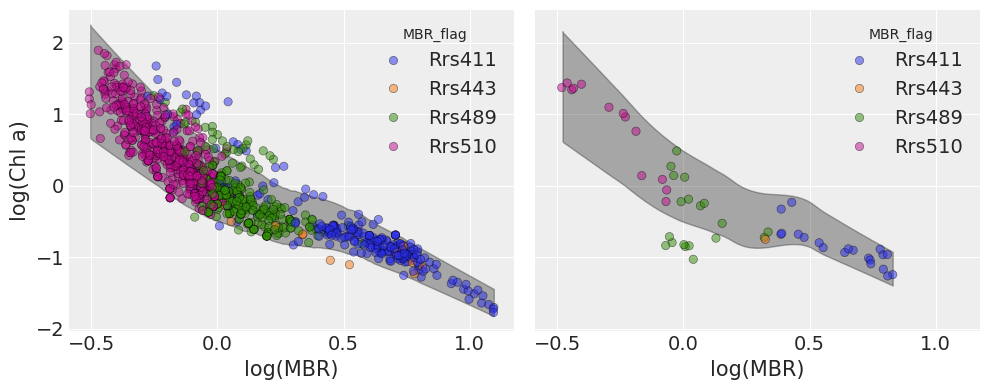

In [96]:
f_cov4, axs_cov4 = plot_regression_hdi_2panel(
    idata4, model4, df_train=df_training, df_test=d_oos)
f_cov4.savefig(img_path / 'model4_predictive_coverage.pdf', dpi=300)

Sampling: [likelihood]


Output()

/var/folders/c9/p_x94m2j357984db558g2n9m0000gn/T/ipykernel_26993/2165081204.py:52: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


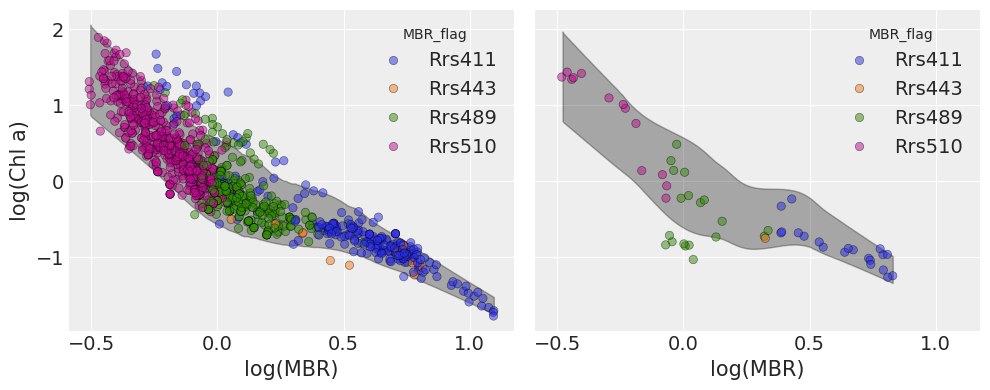

In [117]:
f_cov5, axs_cov5 = plot_regression_hdi_2panel(
    idata5, model5, df_train=df_training, df_test=d_oos)

In [118]:
f_cov5.savefig(img_path / 'model5_predictive_coverage.pdf', dpi=300)

## STEP 6 - Model Comparison

### 1. Side by side evaluation of camparable parameters betwesen models

Here, the idea is that while the model structure evolves, with greater complexity from Models 1-5, some parameters remain the same, or at least comparable in terms of interpretation.

### A Primer on Bayesian Model Comparison: WAIC vs. LOO (and Alternatives)
When comparing Bayesian regression models – such as polynomial regressions, hierarchical partial pooling models, or more complex machine-learning models like BART (Bayesian Additive Regression Trees) – we need techniques that account for both model fit and complexity. All these models have the same likelihood;  a truncated normal $N(\mu,\sigma)$ constrained on the $log(Chl a)$ scale to $[-3, 3.2]$ corresponding to pigment concentrations with $0.001 - 1500 mg\ m^{-3}$, to insure model outputs are realistic. The truncated normal likelihood has mean $\mu$ given by the regression and $\sigma$ a dispersion parameter scale. Beyond this likelihood formulation, models differ in how $\mu$ (and possibly $\sigma$ when heteroscedasticity is assumed) are expressed.

Bayesian model comparison focuses on predictive performance and model evidence, rather than just point estimates. Two popular approaches are the Watanabe–Akaike Information Criterion (WAIC) and Leave-One-Out cross-validation (LOO). We will briefly explain the assumptions and math behind WAIC and LOO, how to use them for Bayesian model selection, and how to implement them in practice (in the present study with the PyMC and ArviZ Python libraries). We’ll also discuss alternative techniques (marginal likelihood/Bayes factors, cross-validation variants, etc.), highlighting strengths and limitations for models that share a likelihood but have differing priors or structures.
### WAIC: Watanabe–Akaike Information Criterion
WAIC (sometimes called Widely Applicable Information Criterion) is a fully Bayesian generalization of classical AIC. WAIC estimates the out-of-sample deviance (or equivalently, expected log predictive density) for a fitted model by using the entire posterior distribution. The key idea is to evaluate how well the model predicts each data point when that data point is treated as new, averaging over the uncertainty in the model parameters. Formally, if $p(y_i \mid \theta)$ is the likelihood for data point $i$ given parameters $\theta$, and we have $S$ posterior draws ${\theta^s}_{s=1}^S$, then the pointwise log predictive density for $y_i$ can be estimated as:

$$ \widehat{\log p(y_i \mid \text{model})} \approx \log \frac{1}{S}\sum_{s=1}^S p(y_i \mid \theta^s) \tag{1} $$

WAIC then adjusts this for model complexity by computing the effective number of parameters $p_{\text{WAIC}}$; the sum of the posterior variances of the log-likelihood for each data point:

$$ p_{\text{WAIC}} = \sum_{i=1}^n \text{Var}_{\theta\sim p(\theta \mid D)}[\log p(y_i \mid \theta)] \tag{2} $$

Intuitively, if the log-likelihood for a given observation varies a lot across the posterior draws, it means the model had to “fit” that data point with many different parameter settings – an indication of flexibility being used (hence a higher effective param count). On the other hand, if the posterior confidently predicts a data point (low variance in log-lik), it’s as if fewer parameters were effectively used for that point. Using these, one can compute the WAIC score (on the deviance scale) as:

   $$ \text{WAIC} = -2 \left( \sum_{i=1}^n \log \frac{1}{S}\sum_{s=1}^S p(y_i \mid \theta^s) - p_{\text{WAIC}} \right) \tag{3} $$

In words, WAIC ≈ –2 * (log predictive accuracy – penalty). A model with lower WAIC is preferred (lower expected deviance = higher predictive accuracy). Equivalently, many software report elpd_WAIC = \text{lppd} - p_{\text{WAIC}}, which is an estimate of the expected log pointwise predictive density; higher elpd is better. WAIC’s formulation makes minimal assumptions (hence “widely applicable”): it works even for models that are not point-identifiable or are “singular” (where traditional asymptotic like BIC fails). The main assumption is that the data are conditionally independent (so the total log-likelihood is sum of pointwise log-likelihoods) and that the posterior draws are representative of the posterior. In our regression models, these conditions hold (each data point contributes a truncated-normal likelihood, independent given $\theta$).

Using WAIC for model selection: WAIC essentially estimates how well the model would predict new data on average. It naturally penalizes model complexity via $p_{\text{WAIC}}$. For example, a simple polynomial regression might have a smaller $p_{\text{WAIC}}$ than a BART model if the latter is using its flexibility to fit fine details. The model with the highest predictive density (lowest WAIC) is generally preferred. In practice, one can look at the standard error of the WAIC (available via jackknife or bootstrap on the pointwise contribution) to judge if differences are meaningful. One must be cautious: if models are very different, WAIC is just a relative metric – it doesn’t tell if either model is absolutely good, just which predicts better. It’s also not valid to interpret WAIC differences like strict probabilities; it’s an information criterion for comparison. 
   
   **Mathematical note**: WAIC has a strong foundation in Bayesian decision theory. In large samples, WAIC is equivalent to Bayesian leave-one-out cross-validation (they both estimate the same quantity: the expected log predictive density). This was proven in the context of “Bayesian predictive information criteria” by Watanabe and others. However, in finite samples WAIC can sometimes under-estimate the effective complexity, especially if the posterior for some points is skewed or if there are influential outliers. In those cases, a related method, PSIS-LOO (described next), is more robust. Nonetheless, WAIC remains a convenient measure as it only requires the posterior draws and the pointwise log-likelihood.

In our scenario, all models have the same likelihood form, so WAIC is comparing how the different prior structures and functional forms (polynomial vs. hierarchical vs. BART, etc.) affect predictive performance. A hierarchical model might achieve a good balance (reducing overfit via partial pooling, thus lower WAIC), whereas an overly flexible model might overfit slightly, increasing its WAIC (worse).



### LOO: Leave-One-Out Cross-Validation (Bayesian)
LOO cross-validation is a direct approach to estimate predictive accuracy: remove each data point in turn, refit (or at least re-evaluate) the model without it, and measure how likely the model would have predicted that left-out point. Repeating this for all points gives an estimate of out-of-sample prediction error. Mathematically, the LOO expected log predictive density (ELPD) is:
   $$ \text{ELPD}_{\text{LOO}} = \sum_{i=1}^n \log p(y_i \mid y_{-i}, M) \tag{4} $$

where $p(y_i \mid y_{-i}, M)$ is the posterior predictive density of $y_i$ given the model $M$ trained on all data except $i$. Computing this exactly is very costly – it would require re-fitting the model $n$ times (for $n$ data points). Fortunately, in Bayesian models we can approximate LOO using the existing full-data posterior draws via importance sampling. The idea (as implemented by Vehtari et al. (2017)
arxiv.org
) is: given draws $\theta^s \sim p(\theta \mid \text{all data})$, we can approximate draws from $p(\theta \mid \text{data minus }i)$ by weighting those draws by $1/p(y_i \mid \theta^s)$. In practice, one computes the LOO log score for each point as:

 $$ \widehat{\log p(y_i \mid y_{-i}, M)} \approx \log \left( \frac{\sum_{s=1}^S w_{is} p(y_i \mid \theta^s)}{\sum_{s=1}^S w_{is}} \right), \quad \text{where} \quad w_{is} = \frac{1}{p(y_i \mid \theta^s)} \tag{5} $$

and uses a clever stabilization called Pareto Smoothed Importance Sampling (PSIS) to avoid a few large weights dominating. The result is an estimate of LOO without separate re-fitting for each point. The sum of these log predictive densities gives $\widehat{\text{ELPD}}_{\text{LOO}}$, often reported as $LOOIC = –2 * {\text{ELPD}}_{\text{LOO}}$ to recast it on the deviance/AIC scale for easier interpretation alongside WAIC. Like WAIC, lower LOOIC (or higher ELPD) indicates better predictive performance.

### WAIC vs LOO

WAIC and LOO both estimate the same target (the model’s expected log predictive accuracy on new data) and are asymptotically equivalent. In finite samples, however, there are differences. WAIC uses the variance of log-likelihood as a penalty; LOO uses the actual leave-one-out approach. If the posterior is approximately multivariate normal and not too sensitive to single points, WAIC and LOO will be very close. PSIS-LOO tends to be more robust when priors are weak or for influential data. Indeed, it’s recommended to prefer PSIS-LOO over WAIC in practice if the computation is feasible, because LOO comes with built-in diagnostics for when it might fail. WAIC has no easy diagnostic to tell if its approximation is off (it might underestimate uncertainty in some cases). In summary, both criteria can be used for model ranking; a significant difference in LOO/WAIC indicates that one model has better predictive performance than the other. If WAIC and LOO disagree noticeably, trust LOO (or actual cross-validation) as it directly assesses predictive fit. In our context (shared truncated-normal likelihood), both WAIC and LOO are applicable. The choice may come down to convenience (WAIC is a one-shot calculation) versus caution (LOO’s diagnostic might alert us if, say, one data point is so extreme that it causes big differences in the hierarchical vs non-hierarchical models’ fits).

In [84]:
df_training.MBR_flag.value_counts()

MBR_flag
Rrs510    540
Rrs489    278
Rrs411    252
Rrs443     12
Name: count, dtype: int64

In [87]:
df_training.MBR_flag.value_counts(normalize=True).round(2)

MBR_flag
Rrs510    0.50
Rrs489    0.26
Rrs411    0.23
Rrs443    0.01
Name: proportion, dtype: float64

In [85]:
d_oos.MBR_flag.value_counts()

MBR_flag
Rrs411    20
Rrs489    19
Rrs510    13
Rrs443     1
Name: count, dtype: int64

In [88]:
d_oos.MBR_flag.value_counts().round(2)

MBR_flag
Rrs411    20
Rrs489    19
Rrs510    13
Rrs443     1
Name: count, dtype: int64

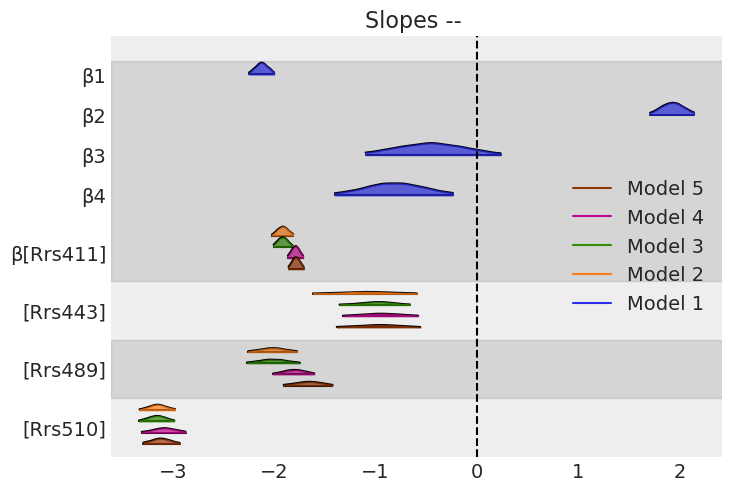

In [99]:
f, ax = pp.subplots()
az.plot_forest(
    [idata1, idata2, idata3, idata4, idata5], 
    model_names=['Model 1','Model 2', 'Model 3', 'Model 4','Model 5'],
    var_names=['β1','β2', 'β3', 'β4', 'β'], combined=True, ax=ax, kind='ridgeplot', ridgeplot_alpha=0.7, hdi_prob=0.94)
ax.set_title('Slopes -- ' + ax.get_title())
ax.axvline(x=0, ls='--', color='k')
f.savefig(img_path / 'post_comp_slopes_all_models.png', dpi=300)

In [102]:
compare_results = az.compare(
    dict(
        model1=idata1, model2=idata2, model3=idata3, model4=idata4, model5=idata5), 
        ic='loo', method='stacking')
# Print the comparison table
compare_results.round(2)

rank  elpd_loo  p_loo  elpd_diff  weight     se    dse  warning scale
model5     0     -0.25  15.27       0.00    0.96  28.11   0.00    False   log
model4     1    -51.73  10.87      51.48    0.00  29.98  10.43    False   log
model3     2   -111.06  14.63     110.81    0.00  27.95  13.41    False   log
model2     3   -114.00   9.88     113.75    0.00  27.59  12.54    False   log
model1     4   -144.54   5.40     144.28    0.04  31.67  21.66    False   log

Inter

In [103]:
compare_results.to_parquet(img_path/'df_post_comp_loocv_all_models.pqt')

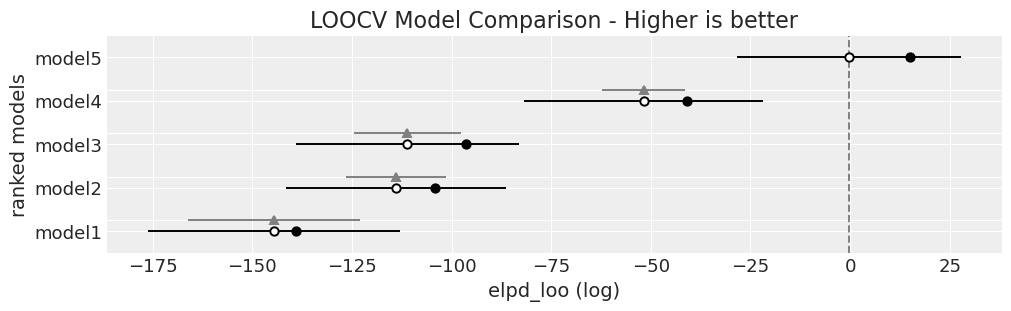

In [150]:
f_comp_loo, ax = pp.subplots(figsize=(10, 3))
az.plot_compare(compare_results, ax=ax, plot_ic_diff=True, insample_dev=True)
ax.set_title('LOOCV Model Comparison - Higher is better')
f_comp_loo.savefig(img_path/'post_comp_loocv_all_models.png', dpi=300)
f_comp_loo.savefig(img_path/'post_comp_loocv_all_models.pdf', dpi=300)

In [105]:
compare_results_waic = az.compare(
    {
        'Model 1': idata1, 
        'Model 2': idata2,
        'Model 3': idata3,
        'Model 4': idata4,
        'Model 5': idata5
        },
    ic='waic'
)

/Users/erdemkarakoylu/miniconda3/envs/pymc_base/lib/python3.12/site-packages/arviz/stats/stats.py:1655: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/Users/erdemkarakoylu/miniconda3/envs/pymc_base/lib/python3.12/site-packages/arviz/stats/stats.py:1655: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/Users/erdemkarakoylu/miniconda3/envs/pymc_base/lib/python3.12/site-packages/arviz/stats/stats.py:1655: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


In [106]:

# Print the comparison table
compare_results_waic.round(2)

rank  elpd_waic  p_waic  elpd_diff  weight     se    dse  warning  \
Model 5     0      -0.06   15.08       0.00    0.96  28.10   0.00     True   
Model 4     1     -51.69   10.82      51.63    0.00  29.98  10.43     True   
Model 3     2    -110.93   14.49     110.87    0.00  27.95  13.40     True   
Model 2     3    -113.97    9.85     113.91    0.00  27.59  12.53    False   
Model 1     4    -144.53    5.39     144.47    0.04  31.67  21.65    False   

        scale  
Model 5   log  
Model 4   log  
Model 3   log  
Model 2   log  
Model 1   log

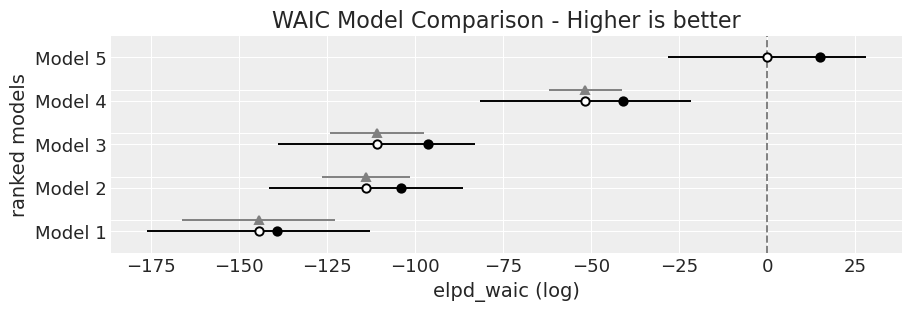

In [151]:
f_comp_waic, ax = pp.subplots(figsize=(9, 3))
az.plot_compare(compare_results_waic, ax=ax, plot_ic_diff=True, insample_dev=True)
ax.set_title('WAIC Model Comparison - Higher is better')
f_comp_waic.savefig(img_path/'post_comp_waic_all_models.png', dpi=300)
f_comp_waic.savefig(img_path/'post_comp_waic_all_models.pdf', dpi=300)

### Model Comparison Using Approximate Leave-One-Out Cross-Validation (suggested for results)

We evaluated predictive performance across candidate models using approximate leave-one-out cross-validation (LOO). The best-performing model incorporated both hierarchical mean and hierarchical heteroscedastic terms, along with a measurement-type-specific dispersion adjustment for fluorescence observations. This model achieved the highest expected log predictive density (ELPD), with a 94% model weight. Notably, the inclusion of fluorescence-specific noise improved performance modestly (ELPD difference: 1.01) relative to the same model without this term. While the ELPD difference was small compared to its standard error, this variant nonetheless showed consistently improved fit without evidence of overfitting (as confirmed by effective parameter count and diagnostics). Simpler models with fixed group-wise noise or linear heteroscedasticity performed substantially worse, and classical polynomial band-ratio models such as Bayesian OC6 showed significantly reduced predictive performance.


### On the Value of Measurement-Aware Noise Modeling (suggested for discussion)

The LOO-based comparison suggests that explicitly modeling the interaction between group structure, input-dependent noise, and measurement method yields modest but consistent improvements in predictive performance. While the gain from adding fluorescence-specific noise dispersion was relatively small, it was robust and interpretable, aligning with posterior residual diagnostics. This result supports the inclusion of domain-informed noise structures in ocean color models, particularly when multiple measurement protocols contribute to training data. Future work should explore richer error structures that include lab- or investigator-specific effects, equipment-level variability, or contextual environmental conditions (e.g., CDOM, turbidity) that could differentially impact measurement precision across techniques.

 Table: Interpretation of LOO Model Comparison Metrics {#tbl-loo-interpretation}


| Metric      | Description                                                  | Interpretation                                                                                    |
| ----------- | ------------------------------------------------------------ | ------------------------------------------------------------------------------------------------- |
| `rank`      | Model ranking by LOO (higher ELPD = better)                  | Rank 0 (H.L. MBR with H.L. Heteroscedasticity + Fluo. Disp.) is the best model                    |
| `elpd_loo`  | Expected log pointwise predictive density (higher is better) | 0.74 vs -144.47 → the best model offers substantially better predictive accuracy than OC6         |
| `p_loo`     | Effective number of parameters                               | 16.27 vs 5.35 → the best model is more flexible and complex than OC6                              |
| `elpd_diff` | Difference in ELPD relative to best model                    | 0 for best, 1.01 for next-best, 145.21 for OC6 → OC6 is substantially worse                       |
| `weight`    | Model weight from LOO-based stacking (sums to 1)             | 0.77 for best model → \~77% probability that it has the best out-of-sample predictive performance |
| `se`        | Standard error of `elpd_loo`                                 | Large values (\~28–32) → modest ELPD differences should be interpreted with caution               |
| `dse`       | Standard error of `elpd_diff`                                | 2.04 between best and second-best → elpd\_diff of 1.01 is \~0.5× dse → difference is modest       |
| `warning`   | Whether LOO diagnostics flagged instability                  | `False` for all models = no evidence of problematic Pareto-k estimates or model misspecification  |
| `scale`     | The log scale is used (log predictive density)               | Correct for continuous outcome models like log(Chlorophyll)                                       |


# Appendix - Formulae

## A. Bayesian Model Comparison:

1. **Pointwise Log Predictive Density**  
   $$ \widehat{\log p(y_i \mid \text{model})} \approx \log \frac{1}{S}\sum_{s=1}^S p(y_i \mid \theta^s) \tag{1} $$

2. **Effective Number of Parameters (for WAIC)**  
   $$ p_{\text{WAIC}} = \sum_{i=1}^n \text{Var}_{\theta\sim p(\theta \mid D)}[\log p(y_i \mid \theta)] \tag{2} $$

3. **WAIC Score (Deviance Scale)**  
   $$ \text{WAIC} = -2 \left( \sum_{i=1}^n \log \frac{1}{S}\sum_{s=1}^S p(y_i \mid \theta^s) - p_{\text{WAIC}} \right) \tag{3} $$

4. **Leave-One-Out Cross-Validation (LOO ELPD)**  
   $$ \text{ELPD}_{\text{LOO}} = \sum_{i=1}^n \log p(y_i \mid y_{-i}, M) \tag{4} $$

5. **Approximation to LOO Log Score Using PSIS**  
   $$ \widehat{\log p(y_i \mid y_{-i}, M)} \approx \log \left( \frac{\sum_{s=1}^S w_{is} p(y_i \mid \theta^s)}{\sum_{s=1}^S w_{is}} \right), \quad \text{where} \quad w_{is} = \frac{1}{p(y_i \mid \theta^s)} \tag{5} $$

6. **Bayes Factor**  
   $$ \text{Bayes Factor} = \frac{p(D \mid M_1)}{p(D \mid M_2)} \tag{6} $$

7. **DIC (Deviance Information Criterion)**  
   $$ \text{DIC} = \bar{D} + p_D, \quad \text{where} \quad \bar{D} = -2 \log p(D \mid \theta), \quad p_D = \bar{D} - D(\bar{\theta}) \tag{7} $$

8. **Stacking (Predictive Distribution Weights)**  
   $$ p(y_i \mid M) = \sum_{m=1}^M w_m p(y_i \mid M_m) \tag{8} $$  
   where $w_m$ are the model weights optimized by maximizing predictive accuracy.
